In [1]:
import os
import sys

curdir = '/home/frederik/Dropbox/GitHub/Magritte/tests/development/'
datdir = f'{curdir}../data/'
moddir = f'{curdir}../models/'
resdir = f'{curdir}../results/'

import numpy             as np
import scipy             as sp
import healpy            as hp
import matplotlib.pyplot as plt
import magritte.tools    as tools
import magritte.setup    as setup
import magritte.mesher   as mesher
import magritte.core     as magritte

from scipy.interpolate import interp1d

# Setup 1: VZ 1, 3D mesher
---

In [2]:
dimension = 3
nrays     = 12*3**2
nspecs    = 5
nlspecs   = 1
nquads    = 1

r_in   = 1.0E13   # [m]
r_out  = 7.8E16   # [m]
nH2_in = 2.0E13   # [m^-3]
temp   = 20.0     # [K]
turb   = 150.00   # [.]

a_or_b = 'a'

get_X_mol = {
    'a' : 1.0E-8,
    'b' : 1.0E-6
}

scale_max = 0.11 * r_out
scale_min = 0.11 * r_in
scale_cte = 0.11 * r_in
scale_fun = f'{scale_cte / r_in**2} * (x*x + y*y + z*z)'

In [ ]:
meshName = f'{moddir}/vanZadelhoff_1_3D_mesher.vtk'

mesher.create_mesh_from_function(
    meshName       = meshName,
    boundary       = mesher.boundary_sphere_in_sphere(
                         radius_in  = r_in,
                         radius_out = r_out),
    scale_min      = scale_min,
    scale_max      = scale_max,
    scale_function = scale_fun )

mesh = mesher.Mesh(meshName)

Info    : Running 'gmsh /home/frederik/Dropbox/GitHub/Magritte/tests/development/../models//vanZadelhoff_1_3D_mesher.geo -3 -saveall -o /home/frederik/Dropbox/GitHub/Magritte/tests/development/../models//vanZadelhoff_1_3D_mesher.vtk' [Gmsh 4.4.1, 1 node, max. 1 thread]
Info    : Started on Wed Mar  3 09:00:43 2021
Info    : Reading '/home/frederik/Dropbox/GitHub/Magritte/tests/development/../models//vanZadelhoff_1_3D_mesher.geo'...
Info    : Done reading '/home/frederik/Dropbox/GitHub/Magritte/tests/development/../models//vanZadelhoff_1_3D_mesher.geo'
Info    : Meshing 1D...
Info    : Meshing curve 101 (Circle)
Info    : Meshing curve 102 (Circle)
Info    : Meshing curve 103 (Circle)
Info    : Meshing curve 104 (Circle)
Info    : Meshing curve 105 (Circle)
Info    : Meshing curve 106 (Circle)
Info    : Meshing curve 107 (Circle)
Info    : Meshing curve 108 (Circle)
Info    : Meshing curve 109 (Circle)
Info    : Meshing curve 110 (Circle)
Info    : Meshing curve 111 (Circle)
Info    : M

In [ ]:
npoints = len(mesh.points)
nbs     = [n for sublist in mesh.neighbors for n in sublist]
n_nbs   = [len(sublist) for sublist in mesh.neighbors]

rs = np.linalg.norm(mesh.points, axis=1)

modelName = f'vanZadelhoff_1{a_or_b}_3D_mesher'
modelFile = f'{moddir}{modelName}.hdf5'
lamdaFile = f'{datdir}test.txt'

X_mol = get_X_mol[a_or_b]

In [5]:
def nH2 (r):
    return nH2_in * np.power(r_in/r, 2.0)

In [6]:
def nTT (r):
    return X_mol * nH2(r)

In [7]:
model = magritte.Model ()
model.parameters.set_spherical_symmetry(False)
model.parameters.set_pop_prec          (1.0e-6)
model.parameters.set_model_name        (modelFile)
model.parameters.set_dimension         (dimension)
model.parameters.set_npoints           (npoints)
model.parameters.set_nrays             (nrays)
model.parameters.set_nspecs            (nspecs)
model.parameters.set_nlspecs           (nlspecs)
model.parameters.set_nquads            (nquads)

model.geometry.points.position.set(mesh.points)
model.geometry.points.velocity.set(np.zeros((npoints, 3)))

model.geometry.points.multiscale.set_all_neighbors(n_nbs, nbs)

model.chemistry.species.abundance = [[     0.0, nTT(r), nH2(r),  0.0,      1.0] for r in rs]
model.chemistry.species.symbol    =  ['dummy0', 'test',   'H2', 'e-', 'dummy1']

model.thermodynamics.temperature.gas  .set( temp                 * np.ones(npoints))
model.thermodynamics.turbulence.vturb2.set((turb/magritte.CC)**2 * np.ones(npoints))

model.parameters.set_nboundary(len(mesh.boundary))
model.geometry.boundary.boundary2point.set(mesh.boundary)

model = setup.set_boundary_condition_CMB  (model)
model = setup.set_uniform_rays            (model)
model = setup.set_linedata_from_LAMDA_file(model, lamdaFile)
model = setup.set_quadrature              (model)

model.write()

# Setup 2: VZ 1, single ray
---

In [330]:
dimension = 1
npoints   = 25
nrays     = 2
nspecs    = 5
nlspecs   = 1
nquads    = 1

r_in   = 1.0E13   # [m]
r_out  = 7.8E16   # [m]
nH2_in = 2.0E13   # [m^-3]
temp   = 2.0E+01  # [K]
turb   = 1.5E+02  # [m/s]

get_X_mol = {
    'a' : 1.0E-8,
    'b' : 1.0E-6
}

# rs = np.logspace (np.log10(r_in), np.log10(r_out), npoints, endpoint=True)
rs = np.linspace (r_in, r_out, npoints, endpoint=True)


def create_model (a_or_b):
    """
    Create a model file for the density distribution benchmark, single ray.
    """

    modelName = f'density_distribution_VZ{a_or_b}_single_ray'
    modelFile = f'{moddir}{modelName}.hdf5'
    lamdaFile = f'{datdir}test.txt'

    X_mol = get_X_mol[a_or_b]

    def nH2 (r):
        return nH2_in * np.power(r_in/r, 2.0)

    def nTT (r):
        return X_mol  * nH2(r)

    model = magritte.Model ()
    model.parameters.set_spherical_symmetry(False)
    model.parameters.set_model_name        (modelFile)
    model.parameters.set_dimension         (dimension)
    model.parameters.set_npoints           (npoints)
    model.parameters.set_nrays             (nrays)
    model.parameters.set_nspecs            (nspecs)
    model.parameters.set_nlspecs           (nlspecs)
    model.parameters.set_nquads            (nquads)

    model.geometry.points.position.set([[r, 0, 0] for r in rs])
    model.geometry.points.velocity.set([[0, 0, 0] for i in range(npoints)])

    model.chemistry.species.abundance = [[     0.0, nTT(r), nH2(r),  0.0,      1.0] for r in rs]
    model.chemistry.species.symbol    =  ['dummy0', 'test',   'H2', 'e-', 'dummy1']

    model.thermodynamics.temperature.gas  .set( temp                 * np.ones(npoints))
    model.thermodynamics.turbulence.vturb2.set((turb/magritte.CC)**2 * np.ones(npoints))

    model = setup.set_Delaunay_neighbor_lists (model)
    model = setup.set_Delaunay_boundary       (model)
    model = setup.set_boundary_condition_CMB  (model)
    model = setup.set_uniform_rays            (model)
    model = setup.set_linedata_from_LAMDA_file(model, lamdaFile)
    model = setup.set_quadrature              (model)

    model.write()

    return magritte.Model (modelFile)

In [331]:
model = create_model ('a')

# Setup 3: all constant, single ray
---

In [2]:
dimension = 1
npoints   = 10
nrays     = 2
nspecs    = 5
nlspecs   = 1
nquads    = 1

nH2  = 1.0E+12                 # [m^-3]
nTT  = 1.0E+03                 # [m^-3]
temp = 4.5E+00                 # [K]
turb = 0.0E+00                 # [m/s]
dx   = 1.0E+12                 # [m]
dv   = 0.0E+00 / magritte.CC   # [fraction of speed of light]

rs = np.array([i*dx for i in range(npoints)])

def create_model ():
    """
    Create a model file for the all_constant benchmark, single ray.
    """

    modelName = f'all_constant_single_ray'
    modelFile = f'{moddir}{modelName}.hdf5'
    lamdaFile = f'{datdir}test.txt'

    model = magritte.Model ()
    model.parameters.set_spherical_symmetry(False)
    model.parameters.set_model_name        (modelFile)
    model.parameters.set_dimension         (dimension)
    model.parameters.set_npoints           (npoints)
    model.parameters.set_nrays             (nrays)
    model.parameters.set_nspecs            (nspecs)
    model.parameters.set_nlspecs           (nlspecs)
    model.parameters.set_nquads            (nquads)

    model.geometry.points.position.set([[i*dx, 0, 0] for i in range(npoints)])
    model.geometry.points.velocity.set([[i*dv, 0, 0] for i in range(npoints)])

    model.chemistry.species.abundance = [[     0.0,    nTT,  nH2,  0.0,      1.0] for _ in range(npoints)]
    model.chemistry.species.symbol    =  ['dummy0', 'test', 'H2', 'e-', 'dummy1']

    model.thermodynamics.temperature.gas  .set( temp                 * np.ones(npoints))
    model.thermodynamics.turbulence.vturb2.set((turb/magritte.CC)**2 * np.ones(npoints))

    model = setup.set_Delaunay_neighbor_lists (model)
    model = setup.set_Delaunay_boundary       (model)
    model = setup.set_boundary_condition_CMB  (model)
    model = setup.set_uniform_rays            (model)
    model = setup.set_linedata_from_LAMDA_file(model, lamdaFile)
    model = setup.set_quadrature              (model)

    model.write()

    return magritte.Model(modelFile)

In [3]:
model = create_model()

In [4]:
ld = model.lines.lineProducingSpecies[0].linedata

k = 0

frq_ = ld.frequency[k]
pop_ = tools.LTEpop         (ld, temp) * nTT
phi_ = tools.profile        (ld, k, temp, (turb/magritte.CC)**2, frq_)
eta_ = tools.lineEmissivity (ld, pop_)[k] * phi_
chi_ = tools.lineOpacity    (ld, pop_)[k] * phi_
src_ = tools.lineSource     (ld, pop_)[k]
bdy_ = tools.I_CMB          (frq_)

def I_0 (x):
    return src_ + (bdy_-src_)*np.exp(-chi_*x)

def I_1 (x):
    return src_ + (bdy_-src_)*np.exp(-chi_*(x[-1]-x))

def u_ (x):
    return 0.5 * (I_0(x) + I_1(x))

# Play!
---

In [5]:
# model = magritte.Model(modelFile)
# model = create_model ('a')

In [6]:
model.compute_spectral_discretisation()
model.compute_inverse_line_widths    ()
model.compute_LTE_level_populations  ()

model.set_eta_and_chi       ()
model.set_boundary_condition()

# eta                = np.array(model.eta,                dtype=np.float64)
# chi                = np.array(model.chi,                dtype=np.float64)
# boundary_condition = np.array(model.boundary_condition, dtype=np.float64)

0

In [26]:
nboundary = 2 #model.parameters.nboundary()
npoints   = model.parameters.npoints  ()
nfreqs    = model.parameters.nfreqs   ()
nrays     = 1 #model.parameters.nrays    ()

In [359]:
eta                = np.array([[1.0] for _ in range(npoints  )])
chi                = np.array([[1.0] for _ in range(npoints  )])
boundary_condition = np.array([[0.0] for _ in range(nboundary)])
boundary_normal    = np.array([[-1.0, 0.0, 0.0], [+1.0, 0.0, 0.0]])

In [28]:
from numba         import njit, jit
from scipy.spatial import cKDTree
from scipy         import sparse

In [384]:
# Rs = np.array(model.geometry.rays.direction, dtype=np.float64)
Rs = np.array([[1,0,0],[-1,0,0]], dtype=np.float64)

boundary2point = np.array(model.geometry.boundary.boundary2point, dtype=np.int64)
point2boundary = np.array(model.geometry.boundary.point2boundary, dtype=np.int64)

# Xs_all = np.array(model.geometry.points.position, dtype=np.float64)

rs = [i for i in range(npoints)]
Xs_all = np.array([[r,0,0] for r in rs], dtype=np.float64)
Xs_bdy = Xs_all[boundary2point]

In [365]:
boundary_normal

array([[-1.,  0.,  0.],
       [ 1.,  0.,  0.]])

In [366]:
Rs

array([[ 1.,  0.,  0.],
       [-1.,  0.,  0.]])

In [376]:
np.dot(boundary_normal, Rs.T)

array([[-1.,  1.],
       [ 1., -1.]])

In [372]:

for ib, bb in enumerate(boundary_normal):
    for ir, rr in enumerate(Rs):
        
        if (np.dot(bb,rr) < 0.0)

ValueError: shapes (2,3) and (2,3) not aligned: 3 (dim 1) != 2 (dim 0)

In [30]:
neighbors       = np.array(model.geometry.points.neighbors,       dtype=np.int64)
n_neighbors     = np.array(model.geometry.points.n_neighbors,     dtype=np.int64)
cum_n_neighbors = np.array(model.geometry.points.cum_n_neighbors, dtype=np.int64)

@njit
def get_neighbors(i):
    return neighbors[cum_n_neighbors[i]:
                     cum_n_neighbors[i]+n_neighbors[i]]

In [148]:
ncp = 3 #npoints #64
dis_all, ind_all = cKDTree(Xs_all).query(Xs_all, ncp)
dis_bdy, ind_bdy = cKDTree(Xs_bdy).query(Xs_bdy, ncp)

dis_bdy = dis_bdy[:,:Xs_bdy.shape[0]]
ind_bdy = ind_bdy[:,:Xs_bdy.shape[0]]


dis_all = dis_all[:,:Xs_all.shape[0]]
ind_all = ind_all[:,:Xs_all.shape[0]]


# def symmetrize(indices):
#     indices = indices.tolist()
#     for p, nn in enumerate(indices):
#         for n in nn:
#             if not p in indices[n]:
#                 indices[n].append(p)
#     return indices

# ind_all = symmetrize(ind_all)
# ind_bdy = symmetrize(ind_bdy)

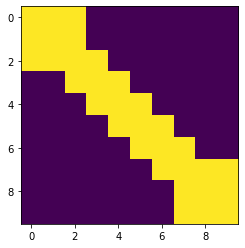

In [146]:
mat = np.zeros((npoints, npoints))
for i, ids in enumerate(ind_all):
    for j in ids:
        mat[i,j] = 1.0
plt.imshow(mat)

In [83]:
def get_datsize_S12():
    # set index
    index = 0
    
    for b1 in range(nboundary):
        p1 = boundary2point[b1]

        index += min([len(ind_all[p1]), npoints])
        
    for p1 in range(npoints):

        index += min([len(ind_all[p1]), npoints])

    return (index + 1) * (nrays * nfreqs)**2


def get_datsize_S22():
    # set index
    index = 0
    
    for b1 in range(nboundary):
        p1 = boundary2point[b1]

        index +=      len(ind_bdy[b1])
        index += min([len(ind_all[p1]), npoints])
        index += min([len(ind_all[p1]), npoints])
        
    for p1 in range(npoints):

        index += min([len(ind_all[p1]), npoints])

    return (index + 1) * (nrays * nfreqs)**2

In [84]:
datsize_S12 = get_datsize_S12()
datsize_S22 = get_datsize_S22()

vecsize = (npoints + nboundary) * nrays * nfreqs

In [85]:
print(datsize_S12)
print(datsize_S22)

121
145


In [86]:
ind_bdy

[[0, 1], [1, 0]]

In [87]:
xs = Xs_all[:,:dimension]

In [88]:
def get_hs_stats():
    """
    Returns for each point the distance to its farthest neighbour,
    and the average distance to all its neighbours.
    """
    # Initialize a new array
    hs_min  = np.zeros(npoints)
    hs_mean = np.zeros(npoints)
    # Loop over all points
    for i in range(npoints):
        # Get distances to neighbours.
        dist = np.linalg.norm(xs[i] - xs[get_neighbors(i)], axis=1)
        hs_min [i] = np.max (dist)
        hs_mean[i] = np.mean(dist)
    return hs_min, hs_mean

In [89]:
hs_min, hs_mean = get_hs_stats()

Computing the gradient based on nearest neighbor information based on Meyer, Eriksson, and Maggio (2001).
For a point at position $\textbf{x}_{i}$, and nearest neighbors $\textbf{x}_{j}$, we can observe that
\begin{equation}
f_{j} - f_{i} \ = \ \left(\textbf{x}_{j} - \textbf{x}_{i} \right) \cdot \nabla f_{i}
\end{equation}

\begin{equation}
\Delta f \ = \ \Delta \textbf{x} \cdot \nabla f
\end{equation}

\begin{equation}
\nabla f \ = \
\left( \Delta \textbf{x} ^{\text{T}} \Delta \textbf{x} \right)^{-1} \ \Delta \textbf{x}^{\text{T}} \Delta f
\end{equation}

In [90]:
def get_grad(ys, xs):
    # Initialize a new array
    grad_ys = np.zeros(xs.shape)
    # In 1D use basic finite difference.    
    if (xs.shape[1] == 1):
        # Unpack xs
        xs = xs[:,0]
        # Finite difference
        dy = np.diff(ys)
        dx = np.diff(xs)
        # Go to second order.
        dy1 = np.concatenate((dy,      [dy[-1]]))
        dy2 = np.concatenate(([dy[0]], dy      ))
        dx1 = np.concatenate((dx,      [dx[-1]]))
        dx2 = np.concatenate(([dx[0]], dx      ))
        # Compose gradient.
        grad_ys = (dy1 + dy2) / (dx1 + dx2)
    # In 2D & 3D use Meyer, Eriksson, and Maggio (2001).
    else:
        # Loop over all points.
        for i in range(npoints):
            nb = get_neighbors(i)
            dx = xs[i] - xs[nb]
            dy = ys[i] - ys[nb]
            grad_ys[i] = np.matmul(np.linalg.inv(np.matmul(dx.T, dx)), np.matmul(dx.T, dy))        
    # return grad
    return grad_ys

In [91]:
# Define the (tabulated) scale function
hs = 4.5*hs_min

# Get the gradient of the log of the (tabulated) scale function 
dlog_hs = get_grad(np.log10(hs), xs)

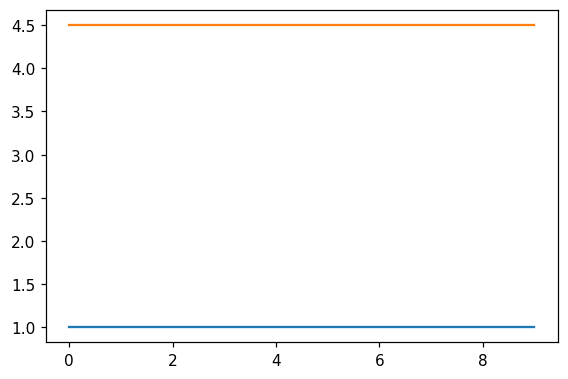

In [92]:
plt.figure(dpi=110)
plt.plot(np.linalg.norm(Xs_all, axis=1), hs_min)
plt.plot(np.linalg.norm(Xs_all, axis=1), hs)
# plt.xscale('log')
# plt.yscale('log')

In [93]:
import jax
import jax.numpy as jnp

# @jit
def RBF_Lucy(r):
    """
    Lucy's smoothing kernel (Lucy 1977).
    """
    # Ensure to take the absolute value
    rr = jnp.abs(r)
    # Compute Lucy's kernel
    if (rr < 1.0):
        return (1.0 + 3.0*rr) * (1 - rr)**3
    else:
        return 0.0
    
    
@njit
def RBF_hexp(r):
    """
    Minus half exponential kernel.
    """
    # Ensure to take the absolute value
    rr = np.abs(r)
    # Compute hexp kernel
    return np.exp(-0.5*rr)

@njit
def grad_RBF_hexp(r):
    return -0.50 * RBF_hexp(r)

@njit
def grad2_RBF_hexp(r):
    return +0.25 * RBF_hexp(r)

Consider a kernel, $k$, of the form
\begin{equation}
k(x,y) \ = \ K \left( \frac{\|x - y\|^2}{h(x) \, h(y)} \right).
\end{equation}
Then one can compute
\begin{equation}
\partial_{y}k(x,y) \ = \ -\frac{1}{h(x) \, h(y)} \left(2\left(x-y\right) + \left(x-y\right)^{2} \partial_{y} \log h(y)\right) K' \left( \frac{\|x - y\|^2}{h(x) \, h(y)} \right).
\end{equation}

In [94]:
# Define kernel
KK       = RBF_Lucy
grad_KK  = jax.grad(KK)
grad2_KK = jax.grad(grad_KK)

In [95]:
# Define kernel
KK       = RBF_hexp
grad_KK  = grad_RBF_hexp
grad2_KK = grad2_RBF_hexp

In [96]:
%timeit KK(0.5)

156 ns ± 4.96 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [97]:
%timeit grad_KK(0.5) 

157 ns ± 3.49 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [98]:
%timeit grad2_KK(0.5) 

153 ns ± 2.66 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


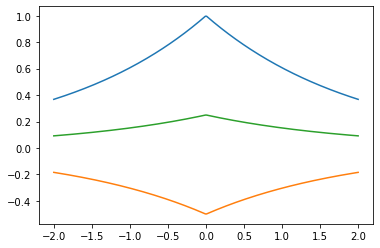

In [99]:
x = np.linspace(-2, 2, 250)

Ks   = [      KK(r) for r in x]
gKs  = [ grad_KK(r) for r in x]
g2Ks = [grad2_KK(r) for r in x]

plt.plot(x,   Ks)
plt.plot(x,  gKs)
plt.plot(x, g2Ks)

In [100]:
hs

array([4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5])

In [101]:
# @njit
def kernel(i1, i2):
    """
    k(x1,x2) = K(|x1-x2|^2 / h(x1)h(x2))
    """
    d = xs[i1] - xs[i2]
    r = np.dot(d,d) / (hs[i1] * hs[i2])
    return KK(r)

In [102]:
# @njit
def d1_kernel(i1, i2):
    """
    ∂k(x1,x2)/∂x2
    """
    d = xs[i1] - xs[i2]
    a = 1.0 / (hs[i1] * hs[i2])
    r = np.dot(d,d) * a
    return (-2.0*d*a - r*dlog_hs[i2]) * grad_KK(r)

# @njit
def d2_kernel(i1, i2):
    """
    ∂k(x1,x2)/∂x1
    """
    d = xs[i1] - xs[i2]
    a = 1.0 / (hs[i1] * hs[i2])
    r = np.dot(d,d) * a
    return (+2.0*d*a - r*dlog_hs[i1]) * grad_KK(r)

# @njit
def d1d2_kernel(i1, i2):
    """
    ∂∂k(x1,x2)/∂x1∂x2
    """
    d = xs[i1] - xs[i2]
    a = 1.0 / (hs[i1] * hs[i2])
    r = np.dot(d,d) * a
    term1 = - 2.0 * a * (1.0 + d*(dlog_hs[i2] - dlog_hs[i1])) \
            - r * dlog_hs[i1] * dlog_hs[i2] 
    term2 =  (+2.0*d*a - r*dlog_hs[i1]) \
            *(-2.0*d*a - r*dlog_hs[i2])
    return term1*grad_KK(r) + term2*grad2_KK(r)

In [103]:
# @njit
def k (r1, p1, f1, r2, p2, f2):
    return kernel(p1,p2)

# @njit
def L1_k(r1, p1, f1, r2, p2, f2):
    """
    L1 k(x1,x2) = (1 + ∇1/χ1) k(x1,x2)
    """
    return kernel(p1,p2) + d1_kernel(p1,p2) / chi[p1,f1]

# @njit
def L2_k(r1, p1, f1, r2, p2, f2):
    """
    L2 k(x1,x2) = (1 + ∇2/χ2) k(x1,x2)
    """
    return kernel(p1,p2) + d2_kernel(p1,p2) / chi[p2,f2]

# @njit
def L1L2_k(r1, p1, f1, r2, p2, f2):
    """
    L1 L2 k(x1,x2) = (1 + ∇1/χ1) (1 + ∇2/χ2) k(x1,x2)
    """
    return kernel(p1,p2) +   d2_kernel(p1,p2) / chi[p2,f2] \
                         +   d1_kernel(p1,p2) / chi[p1,f1] \
                         + d1d2_kernel(p1,p2) / chi[p1,f1] / chi[p2,f2]

WRONG!!!!!!!!!!!!!!!!!!!

\begin{equation}
\left[
\begin{array}{rr}
             f(x_{\texttt{i}}) \\
             f(x_{\texttt{b}}) \\
    \text{L} f(x_{\texttt{a}})
\end{array} 
\right]\
\ \sim \
\mathcal{N}
\left(
    \left[
    \begin{array}{rr}
                 \mu(x_{\texttt{i}}) \\
                 \mu(x_{\texttt{b}}) \\
        \text{L} \mu(x_{\texttt{a}})
    \end{array}
    \right],
    \left[
    \begin{array}{rr}
                   k(x_{\texttt{i}}, x_{\texttt{i}}) &                k(x_{\texttt{b}}, x_{\texttt{i}}       ) &                \text{L}^{(1)} k(x_{\texttt{a}}, x_{\texttt{i}}) \\
                   k(x_{\texttt{i}}, x_{\texttt{b}}) &                k(x_{\texttt{b}}, x_{\texttt{b}}) &                \text{L}^{(1)} k(x_{\texttt{a}}, x_{\texttt{b}}) \\
    \text{L}^{(2)} k(x_{\texttt{i}}, x_{\texttt{a}}) & \text{L}^{(2)} k(x_{\texttt{b}}, x_{\texttt{a}}) & \text{L}^{(2)} \text{L}^{(1)} k(x_{\texttt{a}}, x_{\texttt{a}})
    \end{array}
    \right]
\right) .
\end{equation}

\begin{equation}
\Sigma
\ = \
    \left[
    \begin{array}{r|rr}
                   k(x_{\texttt{i}}, x_{\texttt{i}}) &                k(x_{\texttt{b}}, x_{\texttt{i}}       ) &                \text{L}^{(1)} k(x_{\texttt{a}}, x_{\texttt{i}}) \\ \hline
                   k(x_{\texttt{i}}, x_{\texttt{b}}) &                k(x_{\texttt{b}}, x_{\texttt{b}}) &                \text{L}^{(1)} k(x_{\texttt{a}}, x_{\texttt{b}}) \\
    \text{L}^{(2)} k(x_{\texttt{i}}, x_{\texttt{a}}) & \text{L}^{(2)} k(x_{\texttt{b}}, x_{\texttt{a}}) & \text{L}^{(2)} \text{L}^{(1)} k(x_{\texttt{a}}, x_{\texttt{a}})
    \end{array}
    \right]
\end{equation}

\begin{equation}
\Sigma
\ = \
    \left[
    \begin{array}{l|l}
        \Sigma_{11} & \Sigma_{12} \\ \hline
        \Sigma_{21} & \Sigma_{22}
    \end{array}
    \right]
\end{equation}

\begin{equation}
\Sigma_{12}^{\text{T}} = \Sigma_{21}
\end{equation}

\begin{align}
\dim \left(\Sigma_{11}\right) &= N_{\texttt{a}} \times N_{\texttt{a}} \\
\dim \left(\Sigma_{12}\right) &= N_{\texttt{a}} \times \left(N_{\texttt{a}} + N_{\texttt{b}}\right) \\
\dim \left(\Sigma_{22}\right) &= \left(N_{\texttt{a}} + N_{\texttt{b}}\right) \times \left(N_{\texttt{a}} + N_{\texttt{b}}\right) 
\end{align}

In [104]:
# @njit
def get_Sigma12():
    """
    Σ12 = [ k(xb,xi)  L(1) k(xa,xi) ]
    """
    # initialize
    data = np.zeros(datsize_S12, dtype=np.float64)
    id_i = np.zeros(datsize_S12, dtype=np.int64)
    id_j = np.zeros(datsize_S12, dtype=np.int64)
    # set index
    index = 0
    
    # For all boundary points
    for b2 in range(nboundary):
        p2 = boundary2point[b2]

        # For all (general) points (close to the considered boundary point p1)
        for i1 in range(len(ind_all[p2])):
            p1 = ind_all[p2][i1]
        
            for f2 in range(nfreqs):
                for f1 in range(nfreqs):
            
                    for r2 in range(nrays):
                        for r1 in range(nrays):
            
                            kk = k(r1, p1, f1, r2, p2, f2)
                            j1 = r1 + nrays*(f1 + nfreqs*p1) 
                            j2 = r2 + nrays*(f2 + nfreqs*b2)
                
                            data[index] = kk
                            id_i[index] = j1 
                            id_j[index] = j2
                            index += 1    

    # For all (general) points
    for p2 in range(npoints):
        i2 = p2 + nboundary

        # For all (general) points (close to the considered general point p1)
        for i1 in range(min([len(ind_all[p2]), npoints])):
            p1 = ind_all[p2][i1]
        
            for f2 in range(nfreqs):
                for f1 in range(nfreqs):
                
                    for r2 in range(nrays):
                        for r1 in range(nrays):
                            
                            Lk = L1_k(r1, p1, f1, r2, p2, f2)
                            j1 = r1 + nrays*(f1 + nfreqs*p1) 
                            j2 = r2 + nrays*(f2 + nfreqs*i2)
                            
                            data[index] = Lk
                            id_i[index] = j1
                            id_j[index] = j2
                            index += 1

    return (data, (id_i, id_j))


# @njit
def get_Sigma22():
    """
    Σ22 = [      k(xb,xb)       L(1) k(xa,xb) ]
          [ L(2) k(xb,xa)  L(2) L(1) k(xa,xa) ]
    """
    # initialize
    data = np.zeros(datsize_S22, dtype=np.float64)
    id_i = np.zeros(datsize_S22, dtype=np.int64)
    id_j = np.zeros(datsize_S22, dtype=np.int64)
    # set index
    index = 0
    
    # For all boundary points
    for b1 in range(nboundary):
        p1 = boundary2point[b1]

        # For all boundary points (close to the considered boundary point p1)
        for i2 in range(min([len(ind_bdy[b1]), nboundary])):
            b2 = ind_bdy[b1][i2]
            p2 = boundary2point[b2]
            
            for f1 in range(nfreqs):
                for f2 in range(nfreqs):

                    for r1 in range(nrays):
                        for r2 in range(nrays):  
                                
                            kk = k(r1, p1, f1, r2, p2, f2)
                            j1 = r1 + nrays*(f1 + nfreqs*b1) 
                            j2 = r2 + nrays*(f2 + nfreqs*b2)
                
                            data[index] = kk
                            id_i[index] = j1 
                            id_j[index] = j2
                            index += 1
                            
#                             print ('kk  ', p1, r1, ';', p2, r2, ' ', kk)
 
        # For all (general) points (close to the considered boundary point p1)
        for i2 in range(min([len(ind_all[p1]), npoints])):
            p2 = ind_all[p1][i2]
                    
            for f1 in range(nfreqs):
                for f2 in range(nfreqs):

                    for r1 in range(nrays):
                        for r2 in range(nrays):  
                    
                            Lk = L1_k(r1, p1, f1, r2, p2, f2)
                            j1 = r1 + nrays*(f1 + nfreqs* b1             ) 
                            j2 = r2 + nrays*(f2 + nfreqs*(p2 + nboundary))

                            data[index] = Lk
                            id_i[index] = j1
                            id_j[index] = j2
                            index += 1
                            
                            data[index] = Lk
                            id_i[index] = j2
                            id_j[index] = j1 
                            index += 1
                        
#                             print ('Lk', Lk, p1, r1, p2, r2)
                            
    # For all (general) points
    for p1 in range(npoints):
        i1 = p1 + nboundary

        # For all (general) points (close to the considered general point p1)
        for i2 in range(min([len(ind_all[p1]), npoints])):
            p2 = ind_all[p1][i2]
        
            for f1 in range(nfreqs):
                for f2 in range(nfreqs):
                
                    for r1 in range(nrays):
                        for r2 in range(nrays):
                            
                            L2 = L1L2_k(r1, p1, f1, r2, p2, f2)
                            j1 = r1 + nrays*(f1 + nfreqs* i1             ) 
                            j2 = r2 + nrays*(f2 + nfreqs*(p2 + nboundary))
                            
                            data[index] = L2
                            id_i[index] = j1
                            id_j[index] = j2
                            index += 1
                            
#                             print ('L2  ', p1, r1, ';', p2, r2, ' ', L2)
                            
    print(datsize_S22, index)
    return (data, (id_i, id_j))
 

# @njit
def get_condition():
    """
    condition = [ S    ]
                [ Ibdy ]
    """
    # initialize
    condition = np.zeros(vecsize)

    # For all boundary points
    for i1 in range(nboundary):
        p1 = boundary2point[i1]
        
        for f1 in range(nfreqs):
            
            for r1 in range(nrays):    
                        
                j1 = r1 + nrays*(f1 + nfreqs*i1)
                
#                 condition[j1] = boundary_condition[i1,f1]
                condition[j1] = 0.0

    # For all (general) points
    for p1 in range(npoints):
        i1 = p1 + nboundary
        
        for f1 in range(nfreqs):
            for r1 in range(nrays):

                j1 = r1 + nrays*(f1 + nfreqs* i1)
                
#                 condition[j1] = eta[p1,f1] / chi[p1,f1]
                condition[j1] = 1.0

    return condition

In [105]:
def mylog(x):
#     shape  = x.shape
#     result = np.zeros(shape)
#     x      = np.array(x     ).ravel()
#     result = np.array(result).ravel()
#     print(x.shape)
#     print(result.shape)
#     result[x> 0] =  np.log10( x[x>0])
#     result[x< 0] = -np.log10(-x[x<0])
#     result[x==0] =  np.NaN
#     return result.reshape(shape)
    return np.log10(np.abs(x))

In [106]:
SIGMA22 = get_Sigma22()
Sigma22 = sparse.coo_matrix(SIGMA22, shape=(vecsize, vecsize)).tocsc()

145 144


In [107]:
print(Sigma22.todense())

[[1.         0.13533528 1.         0.92743266 0.81647814 0.68210964
  0.54057407 0.40622047 0.28930124 0.19514083 0.12457146 0.07518627]
 [0.13533528 1.         0.1954843  0.28727704 0.40132736 0.53292334
  0.67259455 0.80670284 0.91936517 0.99543225 1.0237893  1.        ]
 [1.         0.1954843  1.04938272 1.02141012 0.94185648 0.82270551
  0.68062023 0.53315923 0.39532197 0.27732453 0.18395397 0.11528561]
 [0.92743266 0.28727704 1.02141012 1.04938272 1.02141012 0.94185648
  0.82270551 0.68062023 0.53315923 0.39532197 0.27732453 0.18395397]
 [0.81647814 0.40132736 0.94185648 1.02141012 1.04938272 1.02141012
  0.94185648 0.82270551 0.68062023 0.53315923 0.39532197 0.27732453]
 [0.68210964 0.53292334 0.82270551 0.94185648 1.02141012 1.04938272
  1.02141012 0.94185648 0.82270551 0.68062023 0.53315923 0.39532197]
 [0.54057407 0.67259455 0.68062023 0.82270551 0.94185648 1.02141012
  1.04938272 1.02141012 0.94185648 0.82270551 0.68062023 0.53315923]
 [0.40622047 0.80670284 0.53315923 0.6806

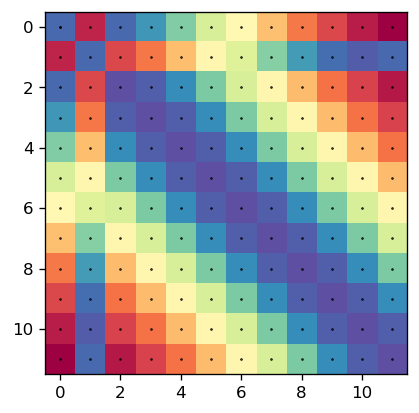

In [108]:
vmin = -np.max(np.abs(Sigma22.todense()))
vmax = +np.max(np.abs(Sigma22.todense()))
plt.figure(dpi=120)
plt.imshow(Sigma22.todense(), cmap='Spectral')
plt.scatter(SIGMA22[1][1], SIGMA22[1][0], c='k', marker='.', s=1)

In [109]:
np.linalg.det(Sigma22.todense())

6.94163877893896e-55

In [110]:
dimsize = npoints * nfreqs * nrays

In [111]:
SIGMA12 = get_Sigma12()
Sigma12 = sparse.coo_matrix(SIGMA12, shape=(dimsize, vecsize)).tocsc()

In [112]:
print(Sigma12.todense())

[[1.         0.13533528 1.         0.92743266 0.81647814 0.68210964
  0.54057407 0.40622047 0.28930124 0.19514083 0.12457146 0.07518627]
 [0.97561098 0.20592425 1.0237893  1.         0.92743266 0.81647814
  0.68210964 0.54057407 0.40622047 0.28930124 0.19514083 0.12457146]
 [0.90595519 0.2982341  0.99543225 1.0237893  1.         0.92743266
  0.81647814 0.68210964 0.54057407 0.40622047 0.28930124 0.19514083]
 [0.8007374  0.41111229 0.91936517 0.99543225 1.0237893  1.
  0.92743266 0.81647814 0.68210964 0.54057407 0.40622047 0.28930124]
 [0.67363846 0.53940751 0.80670284 0.91936517 0.99543225 1.0237893
  1.         0.92743266 0.81647814 0.68210964 0.54057407 0.40622047]
 [0.53940751 0.67363846 0.67259455 0.80670284 0.91936517 0.99543225
  1.0237893  1.         0.92743266 0.81647814 0.68210964 0.54057407]
 [0.41111229 0.8007374  0.53292334 0.67259455 0.80670284 0.91936517
  0.99543225 1.0237893  1.         0.92743266 0.81647814 0.68210964]
 [0.2982341  0.90595519 0.40132736 0.53292334 0.67

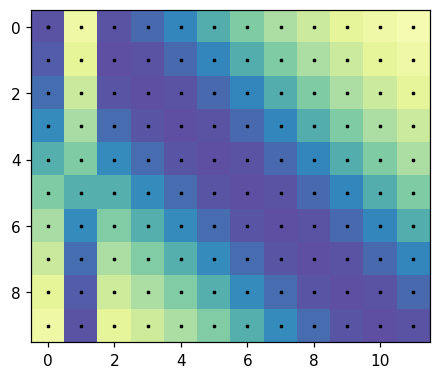

In [113]:
vmin = -np.max(np.abs(Sigma12.todense()))
vmax = +np.max(np.abs(Sigma12.todense()))
plt.figure(dpi=110)
plt.imshow(Sigma12.todense(), cmap='Spectral', vmin=vmin, vmax=vmax)
plt.scatter(SIGMA12[1][1], SIGMA12[1][0], c='k', marker='X', s=2)

In [114]:
condition = get_condition()
condition

array([0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

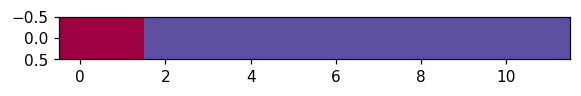

In [115]:
plt.figure(dpi=110)
plt.imshow([condition], cmap='Spectral')

In [116]:
weight = sparse.linalg.spsolve(Sigma22, condition)
result = Sigma12 * weight
result

array([-7.62939453e-06,  2.49954224e-01,  8.16247940e-01,  8.92555237e-01,
        9.86633301e-01,  9.70359802e-01,  1.02189636e+00,  9.45053101e-01,
        1.16831970e+00, -1.06811523e-04])

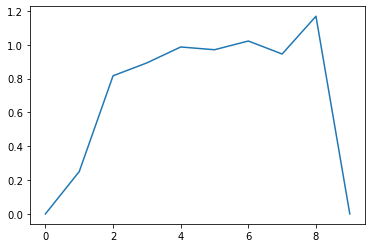

In [117]:
plt.plot(rs, result)

In [300]:
expans.shape

(3, 5)

In [299]:
condition.shape

(10,)

In [298]:
weight.shape

(5,)

In [306]:
result.shape

(3,)

In [19]:
# ld = model.lines.lineProducingSpecies[0].linedata

# k = 0

# frq_ = ld.frequency[k]
# pop_ = tools.LTEpop         (ld, temp) * get_X_mol['a'] * nH2_in
# phi_ = tools.profile        (ld, k, temp, (turb/magritte.CC)**2, frq_)
# eta_ = tools.lineEmissivity (ld, pop_)[k] * phi_
# chi_ = tools.lineOpacity    (ld, pop_)[k] * phi_
# src_ = tools.lineSource     (ld, pop_)[k]
# bdy_ = tools.I_CMB          (frq_)

# def I_0 (x):
#     a = src_
#     b = (bdy_-src_)
#     c = np.exp(-chi_*r_in*(1.0    - r_in/x    ))
#     return a+b*c

# def I_1 (x):
#     return src_ + (bdy_-src_)*np.exp(-chi_*r_in*(r_in/x - r_in/r_out))
# 
# plt.plot(x, I_0(x))
# plt.plot(x, I_1(x))

In [20]:
covariance.todense()

matrix([[ 1.00000000e+00,  3.86592014e-03,  2.23430646e-10,
          2.23406359e-10,  4.97870288e-21,  6.44218562e-33],
        [ 2.23363144e-10,  1.92874985e-22,  3.86592014e-03,
          3.86592014e-03, -4.94854794e-21, -6.41614670e-33],
        [ 6.75020443e-14,  6.75020443e-14,  1.11156676e-23,
         -4.34301808e-25, -1.07819957e-31, -2.12161604e-43],
        [ 4.32156257e-14, -4.26937107e-14,  1.11156676e-23,
         -4.34301808e-25, -4.34301808e-25, -1.07819957e-31],
        [ 4.97870288e-21, -4.94854794e-21,  1.11156676e-23,
         -4.34301808e-25, -4.34301808e-25, -1.07819957e-31],
        [ 6.44218562e-33, -6.41614670e-33,  1.11156676e-23,
         -4.34301808e-25, -1.07819957e-31, -2.12161604e-43]])

In [21]:
result

array([ 2.51339642e-06, -1.58967363e-06, -5.83733916e-13,  2.14001536e-20])

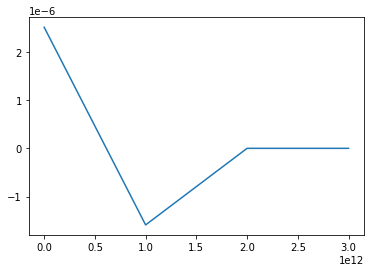

In [22]:
plt.plot(rs, result)
# plt.plot(rs, I_0(rs))
# plt.plot(rs, I_1(rs))
# plt.xscale('log')
# plt.yscale('log')

# Test
---

In [35]:
rs

[0, 1, 2]

In [93]:
x = rs

In [94]:
chi_int = interp1d(rs, chi)

ValueError: x and y arrays must be equal in length along interpolation axis.

In [95]:
plt.plot(x, chi_int(x))
# plt.scatter(x, eta)
plt.scatter(x, chi)
plt.yscale('log')

NameError: name 'chi_int' is not defined

In [26]:
alpha = 1.0

def kernel(x, y, h):
    result = alpha**2 * np.exp(-0.5 * (x-y)**2 / h**2)
    result[result<1.0e-6] = 0.0 
    return result

def Lx_kernel(x, y, h):
    g = (x-y)/(chi_int(x)*h**2)
    return (1.0 - g) * kernel(x, y, h)

def Ly_kernel(x, y, h):
    g = (x-y)/(chi_int(y)*h**2)
    return (1.0 + g) * kernel(x, y, h)

def L2_kernel(x, y, h):
    gx = (x-y)/(chi_int(x)*h**2)
    gy = (x-y)/(chi_int(y)*h**2)
    return ((1.0+gx)*(1.0-gy) + 1.0/(chi_int(x)*chi_int(y)*h**2)) * kernel(x, y, h)

In [27]:
def corr(x, y, h):
    x, y = np.meshgrid(x, y)
    return kernel(x, y, h).T

def Lx_corr(x, y, h):
    x, y = np.meshgrid(x, y)
    return Lx_kernel(x, y, h).T

def Ly_corr(x, y, h):
    x, y = np.meshgrid(x, y)
    return Ly_kernel(x, y, h).T

def L2_corr(x, y, h):
    x, y = np.meshgrid(x, y)
    return L2_kernel(x, y, h).T

In [38]:
alpha = 1.0

def kernel(x, y, h):
    return alpha**2 * np.exp(-0.5 * (x-y)**2 / h**2)


def Lx_dd(x, y, h):
    """
    d_x k(x,y)
    """
    return -(x-y)/h**2 * kernel(x, y, h)

def Lx_od(x, y, h):
    """
    chi(x) k(x,y)
    """
    return chi_int(x) * kernel(x, y, h)


def Ly_dd(x, y, h):
    """
    d_y k(x,y)
    """
    return  (x-y)/h**2 * kernel(x, y, h)

def Ly_od(x, y, h):
    """
    chi(y) k(x,y)
    """
    return chi_int(y) * kernel(x, y, h)


def L2_dd(x, y, h):
    """
    (d_x d_y + chi(x) chi(y)) k(x,y)
    """
    return (chi_int(x)*chi_int(y)*h**4 + h**2 - (x-y)**2) / h**4 * kernel(x, y, h)

def L2_od(x, y, h):
    """
    (chi(x) d_y + chi(y) d_x) k(x,y)
    """
    return (chi_int(x)-chi_int(y))*(x-y) / h**2 * kernel(x, y, h)

In [81]:
def corr(x, y, h):
    x, y = np.meshgrid(x, y)
    return kernel(x, y, h).T

def Lx_dd_corr(x, y, h):
    x, y = np.meshgrid(x, y)
    return Lx_dd(x, y, h).T

def Lx_od_corr(x, y, h):
    x, y = np.meshgrid(x, y)
    return Lx_od(x, y, h).T

def Ly_dd_corr(x, y, h):
    x, y = np.meshgrid(x, y)
    return Ly_dd(x, y, h).T

def Ly_od_corr(x, y, h):
    x, y = np.meshgrid(x, y)
    return Ly_od(x, y, h).T

def L2_dd_corr(x, y, h):
    x, y = np.meshgrid(x, y)
    return L2_dd(x, y, h).T

def L2_od_corr(x, y, h):
    x, y = np.meshgrid(x, y)
    return L2_od(x, y, h).T

In [28]:
def diff(x, y):
    # Compute derivative
    dy = np.diff(y)
    dx = np.diff(x)
    # Compute corresponding x
    x = 0.5*(x[:-1] + x[1:])
    # Return result
    return (x, dy/dx)

def L_operator(x, y):
    x_d, y_d = diff(x, y)
    y_y = 0.5*(y[:-1] + y[1:])
    return (x_d, chi_int(x_d)*y_y + y_d)

In [29]:
import ipywidgets as widgets

x_min = np.min(x)
x_max = np.max(x)

In [30]:
boundary_condition

array([3.77281369e-18, 3.77281369e-18])

In [31]:
 np.concatenate((rs,  rs               )) 

array([0.e+00, 1.e+12, 2.e+12, 3.e+12, 0.e+00, 1.e+12, 2.e+12, 3.e+12])

In [32]:
y_p  = np.array([rs[0]])
fy_p = np.array([boundary_condition[0]])

y_d  = rs #np.linspace(0.0, 2.0, num=5)
fy_d = eta/chi #np.array([eta(d) for d in y_d])


def plot(h):
    
#     x = np.array([0.1])
    
    sigma_00 = corr(x, x, h)

    sigma_10 = np.block([   corr(x, y_p, h),
                         Ly_corr(x, y_d, h) ])
    
    sigma_01 = np.block([   corr(y_p, x, h).T,
                         Lx_corr(y_d, x, h).T ]).T

#     print(   corr(y_p, y_p, h).shape)
#     print(Lx_corr(y_d, y_p, h).T.shape)
#     print(Ly_corr(y_p, y_d, h).shape)
#     print(L2_corr(y_d, y_d, h).shape)
    
    sigma_11 = np.block([[   corr(y_p, y_p, h), Lx_corr(y_d, y_p, h).T],
                         [Ly_corr(y_p, y_d, h).T, L2_corr(y_d, y_d, h)  ] ])

#     print(sigma_00)
#     print(sigma_01)
    print('sigma_10 ', sigma_10.shape)
    print('sigma_11 ', sigma_11.shape)
    
    fy = np.block([fy_p, fy_d])

    print(np.min(sigma_11), np.max(sigma_11), np.linalg.det(sigma_11))
    inv = np.linalg.inv(sigma_11)
    print(np.min(inv     ), np.max(inv     ))
    
#     print(sigma_11)

    
    mean =            np.matmul(np.matmul(sigma_10, np.linalg.inv(sigma_11)), fy)
    cov  = sigma_00 - np.matmul(np.matmul(sigma_10, np.linalg.inv(sigma_11)), sigma_01)

#     print(cov)
    
    xf = np.concatenate((-np.flip(x),x))

    fig = plt.figure(constrained_layout=False, figsize=(5,6), dpi=175)
    gsp = fig.add_gridspec(8, 2, wspace=0.5, hspace=2.1)
    ax1 = fig.add_subplot(gsp[0:2, 0:1])
    ax2 = fig.add_subplot(gsp[0:2, 1:2])
    ax3 = fig.add_subplot(gsp[2:5, 0:2])
    ax4 = fig.add_subplot(gsp[5:8, 0:2])

    ax1.set_title('Correlation function $k$', fontsize=12)
    ax1.plot(xf, kernel(0,xf, h))
    ax1.set_xlabel('$x_1-x_2$')
    ax1.set_ylabel('$k(x_1, x_2)$')
    ax1.set_ylim((-0.05, alpha**2+0.05))

    ax2.set_title('Correlation matrix $\mathbf{\Sigma}_{x | \mathbf{x}}$', fontsize=12)
    ax2.imshow(np.linalg.inv(sigma_11), cmap='Spectral')
    ax2.set_xlabel('index $i$')
    ax2.set_ylabel('index $j$')
    
    asp = np.abs(np.diff(ax1.get_xlim())[0] / np.diff(ax1.get_ylim())[0])
    ax1.set_aspect(asp)

    S = 25
    
    fs = np.random.multivariate_normal(mean, cov, S).T
    
    ax3.set_title('Samples drawn from $\mathcal{N}(\mathbf{\mu}_{x | \mathbf{x}},\mathbf{\Sigma}_{x | \mathbf{x}})$', fontsize=12)
#     ax3.plot(x, fs, c='gray', linewidth=0.2)
    ax3.set_xlim((x_min, x_max))
    ax3.set_xlabel('$x$')
    ax3.set_ylabel('$f(x)$')
    ax3.plot(x, mean, linewidth=0.75, marker='x')
#     ax3.set_yscale('log')
    ax3.plot(x, I_0(x), linewidth=0.75)
    ax3.plot(x, I_1(x), linewidth=0.75)
#     ax3.plot(x, mean+2.0*np.diagonal(cov), linestyle='--', c='red', linewidth=0.5)
#     ax3.plot(x, mean-2.0*np.diagonal(cov), linestyle='--', c='red', linewidth=0.5)

#     ax3.plot(x, np.exp(-x), linewidth=0.75)
    
#     for s in range(S):
#         xs, Ls = L_operator(x, fs[:,s])
#         ax4.plot(xs, Ls, c='gray', linewidth=0.2)
        
    xs, Ls = L_operator(x, mean)
    ax4.plot(xs, Ls, linewidth=0.75)
    ax4.set_xlim((x_min, x_max))
    ax4.set_yscale('log')
    ax4.plot(x, eta, linewidth=0.75)
    
    plt.show()
    
widgets.interact(plot, h=(rs[0], rs[-1], dx))

interactive(children=(FloatSlider(value=1000000000000.0, description='h', max=3000000000000.0, step=1000000000…

<function __main__.plot(h)>

-0.0 23910392824741.31 3.816514145284991e+281
-154.8072424902902 155.8072424902902


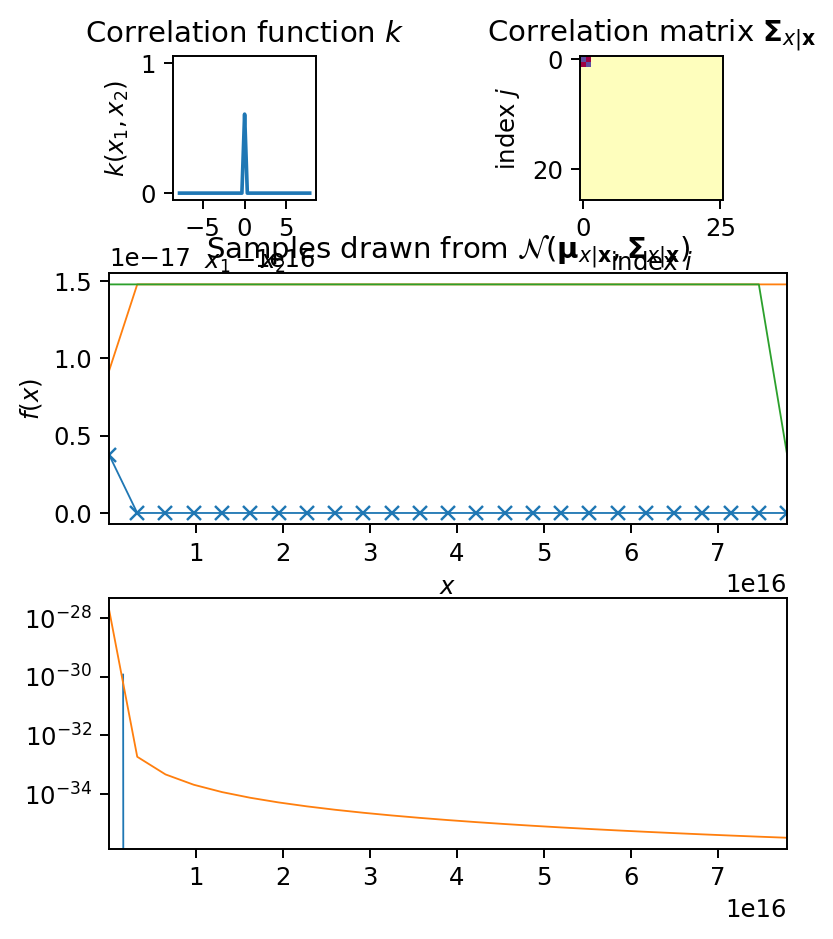

In [364]:
h = rs[0]

sigma_00 = corr(x, x, h)

sigma_10 = np.block([   corr(x, y_p, h),
                     Ly_corr(x, y_d, h) ])
    
sigma_01 = np.block([   corr(y_p, x, h).T,
                     Lx_corr(y_d, x, h).T ]).T

sigma_11 = np.block([[   corr(y_p, y_p, h), Lx_corr(y_d, y_p, h).T],
                     [Ly_corr(y_p, y_d, h).T, L2_corr(y_d, y_d, h)  ] ])
    
fy = np.block([fy_p, fy_d])

print(np.min(sigma_11), np.max(sigma_11), np.linalg.det(sigma_11))
inv = np.linalg.inv(sigma_11)
print(np.min(inv     ), np.max(inv     ))
    
# print(sigma_11)

    
mean =            np.matmul(np.matmul(sigma_10, np.linalg.inv(sigma_11)), fy)
cov  = sigma_00 - np.matmul(np.matmul(sigma_10, np.linalg.inv(sigma_11)), sigma_01)

#     print(cov)
    
xf = np.concatenate((-np.flip(x),x))

fig = plt.figure(constrained_layout=False, figsize=(5,6), dpi=175)
gsp = fig.add_gridspec(8, 2, wspace=0.5, hspace=2.1)
ax1 = fig.add_subplot(gsp[0:2, 0:1])
ax2 = fig.add_subplot(gsp[0:2, 1:2])
ax3 = fig.add_subplot(gsp[2:5, 0:2])
ax4 = fig.add_subplot(gsp[5:8, 0:2])

ax1.set_title('Correlation function $k$', fontsize=12)
ax1.plot(xf, kernel(0,xf, h))
ax1.set_xlabel('$x_1-x_2$')
ax1.set_ylabel('$k(x_1, x_2)$')
ax1.set_ylim((-0.05, alpha**2+0.05))

ax2.set_title('Correlation matrix $\mathbf{\Sigma}_{x | \mathbf{x}}$', fontsize=12)
ax2.imshow(np.linalg.inv(sigma_11), cmap='Spectral')
ax2.set_xlabel('index $i$')
ax2.set_ylabel('index $j$')
    
asp = np.abs(np.diff(ax1.get_xlim())[0] / np.diff(ax1.get_ylim())[0])
ax1.set_aspect(asp)

S = 25
    
fs = np.random.multivariate_normal(mean, cov, S).T
    
ax3.set_title('Samples drawn from $\mathcal{N}(\mathbf{\mu}_{x | \mathbf{x}},\mathbf{\Sigma}_{x | \mathbf{x}})$', fontsize=12)
# ax3.plot(x, fs, c='gray', linewidth=0.2)
ax3.set_xlim((x_min, x_max))
ax3.set_xlabel('$x$')
ax3.set_ylabel('$f(x)$')
ax3.plot(x, mean, linewidth=0.75, marker='x')
# ax3.set_yscale('log')
ax3.plot(x, I_0(x), linewidth=0.75)
ax3.plot(x, I_1(x), linewidth=0.75)
# ax3.plot(x, mean+2.0*np.diagonal(cov), linestyle='--', c='red', linewidth=0.5)
# ax3.plot(x, mean-2.0*np.diagonal(cov), linestyle='--', c='red', linewidth=0.5)

# ax3.plot(x, np.exp(-x), linewidth=0.75)
    
# for s in range(S):
#     xs, Ls = L_operator(x, fs[:,s])
#     ax4.plot(xs, Ls, c='gray', linewidth=0.2)
        
xs, Ls = L_operator(x, mean)
ax4.plot(xs, Ls, linewidth=0.75)
ax4.set_xlim((x_min, x_max))
ax4.set_yscale('log')
ax4.plot(x, eta, linewidth=0.75)
    
plt.show()    

In [88]:
y_p  = np.array([rs[0],                 rs[-1]])                 #np.array([0.0])
fy_p = np.array([boundary_condition[0], boundary_condition[-1]]) #np.array([1.0])

y_d  = np.concatenate((rs,  rs               ))  #np.linspace(0.0, 2.0, num=5)
fy_d = np.concatenate((eta, np.zeros(npoints)))  #eta #np.array([eta(d) for d in y_d])




def plot(h):
    
    print('h = ', h/rs[-1])
    
#     x = np.array([0.1])
    
#     sigma_00 = corr(x, x, h)
    
    kxx = corr(x, x, h)
    sigma_00 = np.block([[kxx,                     np.zeros(kxx.shape)],
                         [np.zeros(kxx.shape),     kxx                ] ])

    kxy_p = corr(x, y_p, h)
    sigma_10 = np.block([[kxy_p,                   np.zeros(kxy_p.shape)],
                         [np.zeros(kxy_p.shape),   kxy_p                ],
                         [Ly_dd_corr(x, y_d, h),   Ly_od_corr(x, y_d, h)],
                         [Ly_od_corr(x, y_d, h),   Ly_dd_corr(x, y_d, h)]])
     
    kyx_p = corr(y_p, x, h)
    sigma_01 = np.block([[kyx_p                .T, np.zeros(kyx_p.shape).T],
                         [np.zeros(kyx_p.shape).T, kyx_p                .T],
                         [Lx_dd_corr(y_d, x, h).T, Lx_od_corr(y_d, x, h).T],
                         [Lx_od_corr(y_d, x, h).T, Lx_dd_corr(y_d, x, h).T] ]).T
    

    
#     print(   corr(y_p, y_p, h).shape)
#     print(Lx_corr(y_d, y_p, h).T.shape)
#     print(Ly_corr(y_p, y_d, h).shape)
#     print(L2_corr(y_d, y_d, h).shape)
    
    kyy_p = corr(y_p, y_p, h)
    sigma_11 = np.block([[kyx_p,                     np.zeros(kyx_p.shape),     Ly_dd_corr(y_p, y_d, h).T, Ly_od_corr(y_p, y_d, h).T],
                         [np.zeros(kyx_p.shape),     kyx_p,                     Ly_od_corr(y_p, y_d, h).T, Ly_dd_corr(y_p, y_d, h).T],
                         [Lx_dd_corr(y_d, y_p, h).T, Lx_od_corr(y_d, y_p, h).T, L2_dd_corr(y_d, y_d, h),   L2_od_corr(y_d, y_d, h)  ],
                         [Lx_od_corr(y_d, y_p, h).T, Lx_dd_corr(y_d, y_p, h).T, L2_od_corr(y_d, y_d, h),   L2_dd_corr(y_d, y_d, h)  ] ])
        
#     sigma_11 = np.block([[   corr(y_p, y_p, h), Lx_corr(y_d, y_p, h).T],
#                          [Ly_corr(y_p, y_d, h).T, L2_corr(y_d, y_d, h)  ] ])

#     print(sigma_00)
#     print(sigma_01)
    print('sigma_10 ', sigma_10.shape)
    print('sigma_11 ', sigma_11.shape)
    
    fy = np.block([fy_p, fy_d])

    print(fy_p.shape)
    print(fy_d.shape),
    print(fy.shape)
    
    mean =            np.matmul(np.matmul(sigma_10, np.linalg.inv(sigma_11)), fy)
    cov  = sigma_00 - np.matmul(np.matmul(sigma_10, np.linalg.inv(sigma_11)), sigma_01)

#     print(cov)
    
    xf = np.concatenate((-np.flip(x),x))

    fig = plt.figure(constrained_layout=False, figsize=(5,13), dpi=175)
    gsp = fig.add_gridspec(14, 2, wspace=0.5, hspace=2.1)
    ax1 = fig.add_subplot(gsp[0:2, 0:1])
    ax2 = fig.add_subplot(gsp[0:2, 1:2])
    ax3 = fig.add_subplot(gsp[2:5, 0:2])
    ax4 = fig.add_subplot(gsp[5:8, 0:2])
    ax5 = fig.add_subplot(gsp[8:11, 0:2])
    ax6 = fig.add_subplot(gsp[11:14, 0:2])

    ax1.set_title('Correlation function $k$', fontsize=12)
    ax1.plot(xf/x[-1], kernel(0,xf, h))
    ax1.set_xlabel('$x_1-x_2$ [r_out]')
    ax1.set_ylabel('$k(x_1, x_2)$')
    ax1.set_ylim((-0.05, alpha**2+0.05))

    ax2.set_title('Correlation matrix $\mathbf{\Sigma}_{x | \mathbf{x}}$', fontsize=12)
    pos = ax2.imshow(cov, vmin=0.0, vmax=np.max(cov))
    ax2.set_xlabel('index $i$')
    ax2.set_ylabel('index $j$')
    fig.colorbar(pos, ax=ax2)
    
    asp = np.abs(np.diff(ax1.get_xlim())[0] / np.diff(ax1.get_ylim())[0])
    ax1.set_aspect(asp)

    S = 25
    
    fs = np.random.multivariate_normal(mean, cov, S).T
    
    ax3.set_title('Samples drawn from $\mathcal{N}(\mathbf{\mu}_{x | \mathbf{x}},\mathbf{\Sigma}_{x | \mathbf{x}})$', fontsize=12)
#     ax3.plot(x, fs, c='gray', linewidth=0.2)
    ax3.set_xlim((x_min, x_max))
    ax3.set_xlabel('$x$')
    ax3.set_ylabel('$f(x)$')
    ax3.plot(x, mean, linewidth=0.75, marker='x')
#     ax3.plot(x, mean+2.0*np.diagonal(cov), linestyle='--', c='red', linewidth=0.5)
#     ax3.plot(x, mean-2.0*np.diagonal(cov), linestyle='--', c='red', linewidth=0.5)

    ax3.plot(x, I_0(x), linewidth=0.75)
    ax3.plot(x, I_1(x), linewidth=0.75)
    ax3.set_yscale('log')
    
#     for s in range(S):
#         xs, Ls = L_operator(x, fs[:,s])
#         ax4.plot(xs, Ls, c='gray', linewidth=0.2)
        
    xs, Ls = L_operator(x, mean)
    ax4.plot(xs, Ls, linewidth=0.75)
    ax4.plot(x, eta, linewidth=0.75)
    ax4.set_xlim((x_min, x_max))
    ax4.set_yscale('log')
    
    
    ax5.set_title('Correlation matrix $\mathbf{\Sigma}_{x | \mathbf{x}}$', fontsize=12)
    pos = ax5.imshow(cov)
    ax5.set_xlabel('index $i$')
    ax5.set_ylabel('index $j$')
    fig.colorbar(pos, ax=ax5)
    
    
    ax6.set_title('Correlation matrix $\mathbf{\Sigma}_{x | \mathbf{x}}$', fontsize=12)
    pos = ax6.imshow(sigma_11)
    ax6.set_xlabel('index $i$')
    ax6.set_ylabel('index $j$')
    fig.colorbar(pos, ax=ax6)
    
    plt.show()
    
widgets.interact(plot, h=(x[0], x[-1]))

interactive(children=(FloatSlider(value=24500000000000.0, description='h', max=49000000000000.0), Output()), _…

<function __main__.plot(h)>

In [40]:
h = rs[-1]

sigma_11 = np.block([[   corr(y_p, y_p, h),   Lx_corr(y_d, y_p, h).T],
                     [Ly_corr(y_p, y_d, h).T, L2_corr(y_d, y_d, h)  ] ])

In [41]:
ss = np.copy(sigma_11)

In [42]:
ss[ss<1.0e-50] = 0.0

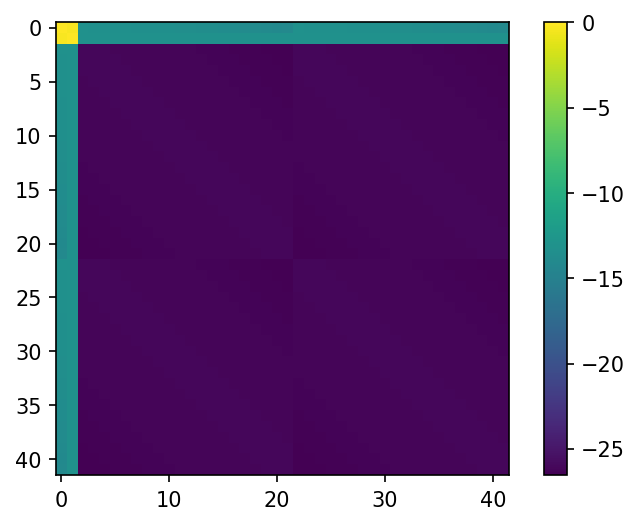

In [43]:
fig = plt.figure(dpi=150)
pos = plt.imshow(np.log10(np.abs(ss)))
fig.colorbar(pos)

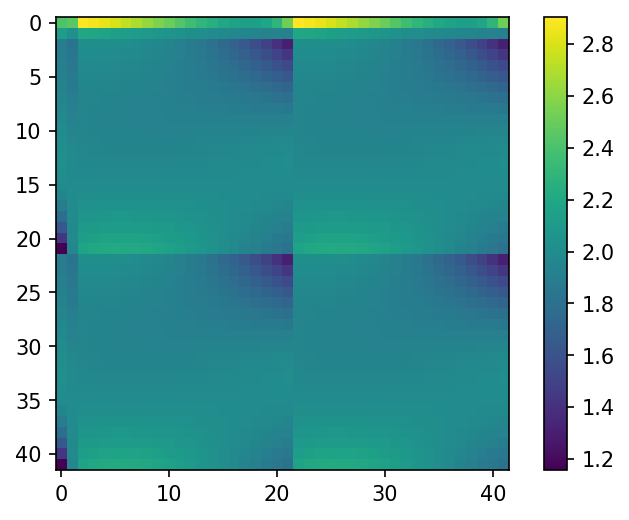

In [44]:
fig = plt.figure(dpi=150)
pos = plt.imshow(tools.relative_error(ss, np.linalg.inv(np.linalg.inv(ss))))
fig.colorbar(pos)

/home/frederik/software/Anaconda3/installation/envs/magritte/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


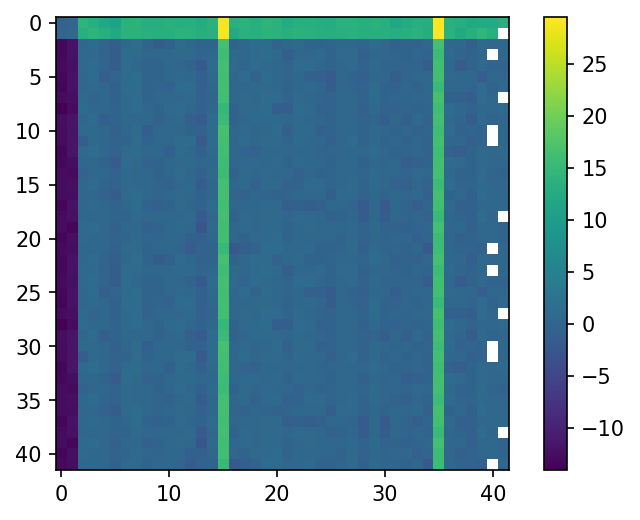

In [45]:
fig = plt.figure(dpi=150)
pos = plt.imshow(np.log10(np.abs(np.matmul(ss, np.linalg.inv(ss)))))
fig.colorbar(pos)

In [46]:
h = rs[1]

sigma_11 = np.block([[   corr(y_p, y_p, h),   Lx_corr(y_d, y_p, h).T],
                     [Ly_corr(y_p, y_d, h).T, L2_corr(y_d, y_d, h)  ] ])

In [47]:
def plot(h):
    
    sigma_00 = corr(x, x, h)

    sigma_10 = np.block([   corr(x, y_p, h),
                         Ly_corr(x, y_d, h) ])
    
    sigma_01 = np.block([   corr(y_p, x, h).T,
                         Lx_corr(y_d, x, h).T ]).T
    
    
    sigma_11 = np.block([[   corr(y_p, y_p, h), Lx_corr(y_d, y_p, h).T],
                         [Ly_corr(y_p, y_d, h).T, L2_corr(y_d, y_d, h)  ] ])

    
    fy = np.block([fy_p, fy_d])

    
    mean =            np.matmul(np.matmul(sigma_10, np.linalg.inv(sigma_11)), fy)
    cov  = sigma_00 - np.matmul(np.matmul(sigma_10, np.linalg.inv(sigma_11)), sigma_01)

#     print(cov)
    
    xf = np.concatenate((-np.flip(x),x))

    fig = plt.figure(constrained_layout=False, figsize=(14,16), dpi=175)
    gsp = fig.add_gridspec(3, 2)
    ax1 = fig.add_subplot(gsp[0])
    ax2 = fig.add_subplot(gsp[1])
    ax3 = fig.add_subplot(gsp[2])
    ax4 = fig.add_subplot(gsp[3])
    ax5 = fig.add_subplot(gsp[4])
    ax6 = fig.add_subplot(gsp[5])

#     ax1.set_title('Correlation matrix $\mathbf{\Sigma}_{x | \mathbf{x}}$', fontsize=12)
#     pos = ax1.imshow(cov)
#     ax5.set_xlabel('index $i$')
#     ax5.set_ylabel('index $j$')
#     fig.colorbar(pos, ax=ax5)
    
    
    ax1.set_title('+sigma_11')
    pos = ax1.imshow(np.log10(sigma_11))
#     ax1.set_xlabel('index $i$')
#     ax1.set_ylabel('index $j$')
    fig.colorbar(pos, ax=ax1)
    
    ax2.set_title('-sigma_11')
    pos = ax2.imshow(np.log10(-sigma_11))
#     ax2.set_xlabel('index $i$')
#     ax2.set_ylabel('index $j$')
    fig.colorbar(pos, ax=ax2)
    
    ax3.set_title('+cov')
    pos = ax3.imshow(np.log10(cov))
#     ax3.set_xlabel('index $i$')
#     ax3.set_ylabel('index $j$')
    fig.colorbar(pos, ax=ax3)
    
    ax4.set_title('-cov')
    pos = ax4.imshow(np.log10(-cov))
#     ax4.set_xlabel('index $i$')
#     ax4.set_ylabel('index $j$')
    fig.colorbar(pos, ax=ax4)
    
    ax5.set_title('+inverse_sigma_11')
    pos = ax5.imshow(np.log10(np.linalg.inv(sigma_11)))
#     ax5.set_xlabel('index $i$')
#     ax5.set_ylabel('index $j$')
    fig.colorbar(pos, ax=ax5)
    
    ax6.set_title('-inverse_sigma_11')
    pos = ax6.imshow(np.log10(-np.linalg.inv(sigma_11)))
#     ax4.set_xlabel('index $i$')
#     ax4.set_ylabel('index $j$')
    fig.colorbar(pos, ax=ax6)
    
    plt.show()
    
widgets.interact(plot, h=(x[0], x[-1]))

interactive(children=(FloatSlider(value=9500000000000.0, description='h', max=19000000000000.0), Output()), _d…

<function __main__.plot(h)>

In [48]:
def plot(h):
    
    sigma_00 = corr(x, x, h)

    sigma_10 = np.block([   corr(x, y_p, h),
                         Ly_corr(x, y_d, h) ])
    
    sigma_01 = np.block([   corr(y_p, x, h).T,
                         Lx_corr(y_d, x, h).T ]).T
    
    
    sigma_11 = np.block([[   corr(y_p, y_p, h), Lx_corr(y_d, y_p, h).T],
                         [Ly_corr(y_p, y_d, h).T, L2_corr(y_d, y_d, h)  ] ])

    
    fy = np.block([fy_p, fy_d])

    
    mean =            np.matmul(np.matmul(sigma_10, np.linalg.inv(sigma_11)), fy)
    cov  = sigma_00 - np.matmul(np.matmul(sigma_10, np.linalg.inv(sigma_11)), sigma_01)

#     print(cov)
    
    xf = np.concatenate((-np.flip(x),x))

    fig = plt.figure(constrained_layout=False, figsize=(14,16), dpi=100)
    gsp = fig.add_gridspec(2, 1)
    ax1 = fig.add_subplot(gsp[0])
    ax3 = fig.add_subplot(gsp[1])


#     ax1.set_title('Correlation matrix $\mathbf{\Sigma}_{x | \mathbf{x}}$', fontsize=12)
#     pos = ax1.imshow(cov)
#     ax5.set_xlabel('index $i$')
#     ax5.set_ylabel('index $j$')
#     fig.colorbar(pos, ax=ax5)
    
    
    ax1.set_title('+sigma_11')
    pos = ax1.imshow(np.log10(tools.relative_error(sigma_11, sigma_11.T)))
#     ax1.set_xlabel('index $i$')
#     ax1.set_ylabel('index $j$')
    fig.colorbar(pos, ax=ax1)
    
    ax3.set_title('+cov')
    pos = ax3.imshow(np.log10(tools.relative_error(cov, cov.T)))
#     ax3.set_xlabel('index $i$')
#     ax3.set_ylabel('index $j$')
    fig.colorbar(pos, ax=ax3)
    
    plt.show()

    print(tools.relative_error(sigma_11, sigma_11.T))
    print(tools.relative_error(cov,      cov.T     ))
    
widgets.interact(plot, h=(x[0], x[-1]))

interactive(children=(FloatSlider(value=9500000000000.0, description='h', max=19000000000000.0), Output()), _d…

<function __main__.plot(h)>

In [72]:
def mylog(x):
    result = np.zeros(x.shape)
    result[x>0] =  np.log(x[x>0])
#     result[x<0] = -np.log(x[x<0])
    return result

In [73]:
mylog(sigma_11)

array([[  0.        , -30.32661851,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ],
       [-30.32661851, -55.25749606, -61.15323702,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ],
       [  0.        , -61.15323702, -55.25749606, -61.15323702,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.    

array([[ 0.,  0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., -0., -0.],
       [ 0.,  0.,  0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., -0., -0.],
       [-0.,  0.,  0.,  0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., -0., -0.],
       [-0., -0.,  0.,  0.,  0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., -0., -0.],
       [-0., -0., -0.,  0.,  0.,  0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., -0., -0.],
       [-0., -0., -0., -0.,  0.,  0.,  0., -0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., -0., -0.],
       [-0., -0., -0., -0., -0.,  0.,  0.,  0., -0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., -0., -0.],
       [-0., -0., -0., -0., -0., -0.,  0.,  0.,  0., -0., -0., -0., -0.,
        -0., -0., -0., -0., -0., -0., -0., -0.],
       [-0., -0., -0., -

In [139]:
sigma_00 = corr(x, x, h)

sigma_10 = np.block([   corr(x, y_p, h),
                     Ly_corr(x, y_d, h) ])
    
sigma_01 = np.block([   corr(y_p, x, h).T,
                     Lx_corr(y_d, x, h).T ]).T
    
sigma_11 = np.block([[   corr(y_p, y_p, h), Lx_corr(y_d, y_p, h).T],
                     [Ly_corr(y_p, y_d, h).T, L2_corr(y_d, y_d, h)  ] ])

fy = np.block([fy_p, fy_d])

In [148]:
sigma_11.shape

(4, 4)

In [147]:
covariance.toarray().shape

(5, 5)

In [146]:
fy

array([3.77281369e-18, 9.97040097e-31, 9.97040097e-31, 9.97040097e-31])

In [145]:
condition

array([3.77281369e-18, 3.77281369e-18, 9.97040097e-31, 9.97040097e-31,
       9.97040097e-31])

In [120]:
np.range(npoints, nrays, nfreqs).

SyntaxError: invalid syntax (<ipython-input-120-37ddcf55e0f7>, line 1)

In [150]:
ind_all

array([[0, 1, 2],
       [1, 2, 0],
       [2, 3, 1],
       [3, 4, 2],
       [4, 5, 3],
       [5, 6, 4],
       [6, 7, 5],
       [7, 8, 6],
       [8, 9, 7],
       [9, 8, 7]])

In [207]:
red0 = np.array([[0],[1]])
red1 = np.array([[0,1], [0,1], [1,2]])
red2 = np.array([[0],[1],[2],[3]])

In [208]:
reds = (red0,red1,red2)

In [175]:
indices[1,0,1]

13

In [173]:
n0 = 2
n1 = 3
n2 = 4

dims     = (n0, n1, n2)
reductions = (inds, np.arange(n1*n1), np.arange(n2))

# (Total) dimension of linearised space.
dims_tot = np.prod(dims)
indices  = np.arange(dims_tot).reshape(dims)



In [222]:
indices[red0[0],red1[0],red2[0]]

array([0, 4])

In [177]:
for j, red in enumerate(reds):
    
    for i in red:
    
        print(j, i)

0 0
1 0
1 1
1 2
2 0
2 1
2 2
2 3


In [214]:
reds

(array([[0],
        [1]]),
 array([[0, 1],
        [0, 1],
        [1, 2]]),
 array([[0],
        [1],
        [2],
        [3]]))

In [218]:
def get_reduced_indices(ii1):
    return indices[reds[0][ii1[0]],...]

In [216]:
indices[[0,1],:,:]

array([[[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11]],

       [[12, 13, 14, 15],
        [16, 17, 18, 19],
        [20, 21, 22, 23]]])

[array([[1, 2],
        [1, 2],
        [1, 2]]),
 array([[4, 4],
        [5, 5],
        [6, 6]])]

In [241]:
np.meshgrid([1],[2,3], [4,5,6])

[array([[[1, 1, 1]],
 
        [[1, 1, 1]]]),
 array([[[2, 2, 2]],
 
        [[3, 3, 3]]]),
 array([[[4, 5, 6]],
 
        [[4, 5, 6]]])]

In [261]:
inds = np.array([1,2,3])

In [305]:
reds

(array([[0],
        [1]]),
 array([[0, 1],
        [0, 1],
        [1, 2]]),
 array([[0],
        [1],
        [2],
        [3]]))

In [298]:
@njit
def reductions(inds):
    return 

In [300]:
reductions((0,2,2))

[array([0]), array([1, 2]), array([2])]

In [303]:
*[1,2,4]

SyntaxError: can't use starred expression here (<ipython-input-303-74841af24aa2>, line 4)

In [307]:
import itertools


inds = (0,2,2)

reductions = [red[ind] for (red, ind) in zip(reds, inds)]

print(reductions)

for ind in itertools.product(*reductions):
    print(ind)

[array([0]), array([1, 2]), array([2])]
(0, 1, 2)
(0, 2, 2)


In [273]:
get()

SyntaxError: can't use starred expression here (<ipython-input-273-bbd1fec3ac19>, line 4)

In [243]:
for inds in np.nditer(np.meshgrid([1,2],[4,5,6],[7,8,9])):
    print(inds)

(array(1), array(4), array(7))
(array(1), array(4), array(8))
(array(1), array(4), array(9))
(array(2), array(4), array(7))
(array(2), array(4), array(8))
(array(2), array(4), array(9))
(array(1), array(5), array(7))
(array(1), array(5), array(8))
(array(1), array(5), array(9))
(array(2), array(5), array(7))
(array(2), array(5), array(8))
(array(2), array(5), array(9))
(array(1), array(6), array(7))
(array(1), array(6), array(8))
(array(1), array(6), array(9))
(array(2), array(6), array(7))
(array(2), array(6), array(8))
(array(2), array(6), array(9))


In [310]:
for ii1, i1 in np.ndenumerate(indices):
    
    for ii2 in itertools.product(*[red[i] for red, i in zip(reds, ii1)]):

    
        print(f'{ii2}')

(0, 0, 0)
(0, 1, 0)
(0, 0, 1)
(0, 1, 1)
(0, 0, 2)
(0, 1, 2)
(0, 0, 3)
(0, 1, 3)
(0, 0, 0)
(0, 1, 0)
(0, 0, 1)
(0, 1, 1)
(0, 0, 2)
(0, 1, 2)
(0, 0, 3)
(0, 1, 3)
(0, 1, 0)
(0, 2, 0)
(0, 1, 1)
(0, 2, 1)
(0, 1, 2)
(0, 2, 2)
(0, 1, 3)
(0, 2, 3)
(1, 0, 0)
(1, 1, 0)
(1, 0, 1)
(1, 1, 1)
(1, 0, 2)
(1, 1, 2)
(1, 0, 3)
(1, 1, 3)
(1, 0, 0)
(1, 1, 0)
(1, 0, 1)
(1, 1, 1)
(1, 0, 2)
(1, 1, 2)
(1, 0, 3)
(1, 1, 3)
(1, 1, 0)
(1, 2, 0)
(1, 1, 1)
(1, 2, 1)
(1, 1, 2)
(1, 2, 2)
(1, 1, 3)
(1, 2, 3)


In [147]:
ind_all

[[0, 1, 2],
 [1, 2, 0],
 [2, 3, 1, 0],
 [3, 4, 2],
 [4, 5, 3],
 [5, 6, 4],
 [6, 7, 5],
 [7, 8, 6, 9],
 [8, 9, 7],
 [9, 8, 7]]

In [ ]:
for (p1, r1, f1), i1 in np.nditer(indices)

In [104]:
# @njit
def get_Sigma12():
    """
    Σ12 = [ k(xb,xi)  L(1) k(xa,xi) ]
    """
    # initialize
    data = np.zeros(datsize_S12, dtype=np.float64)
    id_i = np.zeros(datsize_S12, dtype=np.int64)
    id_j = np.zeros(datsize_S12, dtype=np.int64)
    # set index
    index = 0
    
    # For all boundary points
    for b2 in range(nboundary):
        p2 = boundary2point[b2]

        # For all (general) points (close to the considered boundary point p1)
        for i1 in range(len(ind_all[p2])):
            p1 = ind_all[p2][i1]
        
            for f2 in range(nfreqs):
                for f1 in range(nfreqs):
            
                    for r2 in range(nrays):
                        for r1 in range(nrays):
            
                            kk = k(r1, p1, f1, r2, p2, f2)
                            j1 = r1 + nrays*(f1 + nfreqs*p1) 
                            j2 = r2 + nrays*(f2 + nfreqs*b2)
                
                            data[index] = kk
                            id_i[index] = j1 
                            id_j[index] = j2
                            index += 1    

    # For all (general) points
    for p2 in range(npoints):
        i2 = p2 + nboundary

        # For all (general) points (close to the considered general point p1)
        for i1 in range(min([len(ind_all[p2]), npoints])):
            p1 = ind_all[p2][i1]
        
            for f2 in range(nfreqs):
                for f1 in range(nfreqs):
                
                    for r2 in range(nrays):
                        for r1 in range(nrays):
                            
                            Lk = L1_k(r1, p1, f1, r2, p2, f2)
                            j1 = r1 + nrays*(f1 + nfreqs*p1) 
                            j2 = r2 + nrays*(f2 + nfreqs*i2)
                            
                            data[index] = Lk
                            id_i[index] = j1
                            id_j[index] = j2
                            index += 1

    return (data, (id_i, id_j))


# @njit
def get_Sigma22():
    """
    Σ22 = [      k(xb,xb)       L(1) k(xa,xb) ]
          [ L(2) k(xb,xa)  L(2) L(1) k(xa,xa) ]
    """
    # initialize
    data = np.zeros(datsize_S22, dtype=np.float64)
    id_i = np.zeros(datsize_S22, dtype=np.int64)
    id_j = np.zeros(datsize_S22, dtype=np.int64)
    # set index
    index = 0
    
    # For all boundary points
    for b1 in range(nboundary):
        p1 = boundary2point[b1]

        # For all boundary points (close to the considered boundary point p1)
        for i2 in range(min([len(ind_bdy[b1]), nboundary])):
            b2 = ind_bdy[b1][i2]
            p2 = boundary2point[b2]
            
            for f1 in range(nfreqs):
                for f2 in range(nfreqs):

                    for r1 in range(nrays):
                        for r2 in range(nrays):  
                                
                            kk = k(r1, p1, f1, r2, p2, f2)
                            j1 = r1 + nrays*(f1 + nfreqs*b1) 
                            j2 = r2 + nrays*(f2 + nfreqs*b2)
                
                            data[index] = kk
                            id_i[index] = j1 
                            id_j[index] = j2
                            index += 1
                            
#                             print ('kk  ', p1, r1, ';', p2, r2, ' ', kk)
 
        # For all (general) points (close to the considered boundary point p1)
        for i2 in range(min([len(ind_all[p1]), npoints])):
            p2 = ind_all[p1][i2]
                    
            for f1 in range(nfreqs):
                for f2 in range(nfreqs):

                    for r1 in range(nrays):
                        for r2 in range(nrays):  
                    
                            Lk = L1_k(r1, p1, f1, r2, p2, f2)
                            j1 = r1 + nrays*(f1 + nfreqs* b1             ) 
                            j2 = r2 + nrays*(f2 + nfreqs*(p2 + nboundary))

                            data[index] = Lk
                            id_i[index] = j1
                            id_j[index] = j2
                            index += 1
                            
                            data[index] = Lk
                            id_i[index] = j2
                            id_j[index] = j1 
                            index += 1
                        
#                             print ('Lk', Lk, p1, r1, p2, r2)
                            
    # For all (general) points
    for p1 in range(npoints):
        i1 = p1 + nboundary

        # For all (general) points (close to the considered general point p1)
        for i2 in range(min([len(ind_all[p1]), npoints])):
            p2 = ind_all[p1][i2]
        
            for f1 in range(nfreqs):
                for f2 in range(nfreqs):
                
                    for r1 in range(nrays):
                        for r2 in range(nrays):
                            
                            L2 = L1L2_k(r1, p1, f1, r2, p2, f2)
                            j1 = r1 + nrays*(f1 + nfreqs* i1             ) 
                            j2 = r2 + nrays*(f2 + nfreqs*(p2 + nboundary))
                            
                            data[index] = L2
                            id_i[index] = j1
                            id_j[index] = j2
                            index += 1
                            
#                             print ('L2  ', p1, r1, ';', p2, r2, ' ', L2)
                            
    print(datsize_S22, index)
    return (data, (id_i, id_j))
 

# @njit
def get_condition():
    """
    condition = [ S    ]
                [ Ibdy ]
    """
    # initialize
    condition = np.zeros(vecsize)

    # For all boundary points
    for i1 in range(nboundary):
        p1 = boundary2point[i1]
        
        for f1 in range(nfreqs):
            
            for r1 in range(nrays):    
                        
                j1 = r1 + nrays*(f1 + nfreqs*i1)
                
#                 condition[j1] = boundary_condition[i1,f1]
                condition[j1] = 0.0

    # For all (general) points
    for p1 in range(npoints):
        i1 = p1 + nboundary
        
        for f1 in range(nfreqs):
            for r1 in range(nrays):

                j1 = r1 + nrays*(f1 + nfreqs* i1)
                
#                 condition[j1] = eta[p1,f1] / chi[p1,f1]
                condition[j1] = 1.0

    return condition

\begin{equation}
\left[
\begin{array}{rr}
             f(x_{\texttt{i}}) \\
    \text{B} f(x_{\texttt{b}}) \\
    \text{L} f(x_{\texttt{a}})
\end{array} 
\right]\
\ \sim \
\mathcal{N}
\left(
    \left[
    \begin{array}{rr}
                 \mu(x_{\texttt{i}}) \\
        \text{B} \mu(x_{\texttt{b}}) \\
        \text{L} \mu(x_{\texttt{a}})
    \end{array}
    \right],
    \left[
    \begin{array}{rrr}
                   k(x_{\texttt{i}}, x_{\texttt{i}}) &                \text{B}^{(1)} k(x_{\texttt{b}}, x_{\texttt{i}}) &                \text{L}^{(1)} k(x_{\texttt{a}}, x_{\texttt{i}}) \\
    \text{B}^{(2)} k(x_{\texttt{i}}, x_{\texttt{b}}) & \text{B}^{(2)} \text{B}^{(1)} k(x_{\texttt{b}}, x_{\texttt{b}}) & \text{B}^{(2)} \text{L}^{(1)} k(x_{\texttt{a}}, x_{\texttt{b}}) \\
    \text{L}^{(2)} k(x_{\texttt{i}}, x_{\texttt{a}}) & \text{L}^{(2)} \text{B}^{(1)} k(x_{\texttt{b}}, x_{\texttt{a}}) & \text{L}^{(2)} \text{L}^{(1)} k(x_{\texttt{a}}, x_{\texttt{a}})
    \end{array}
    \right]
\right) .
\end{equation}

In [427]:
# Specify dimensions of (sub-spaces of) the domain
xdim_blk = [npoints,   nfreqs, nrays]
xdim_bdy = [nboundary, nfreqs, nrays]
# Specify dimensions of (sub-spaces of) the codomain
ydim_blk = [2]
ydim_bdy = [1]
# Get total dims
dims_blk = xdim_blk + ydim_blk
dims_bdy = xdim_bdy + ydim_bdy
# Initialize indices and reductions
inds_blk = [np.arange(dim) for dim in dims_blk]
inds_bdy = [np.arange(dim) for dim in dims_bdy]
# (Optionally) specify reductions of sub-spaces
REDS_blk = [np.arange(dim) for dim in dims_blk]
def reds_blk(ii):
    REDS_blk[0] = ind_all[ii[0]]
    return REDS_blk
REDS_bdy = [np.arange(dim) for dim in dims_bdy]
def reds_bdy(ii):
    REDS_bdy[0] = ind_bdy[ii[0]]
    return REDS_bdy
# Get dimensions of linearised spaces
dim_blk = np.prod(dims_blk)
dim_bdy = np.prod(dims_bdy)
dim_tot = dim_blk + dim_bdy
# Get indices of linearised spaces
linds_blk = np.arange(dim_blk).reshape(dims_blk)
linds_bdy = np.arange(dim_bdy).reshape(dims_bdy)

def bdy_2_blk(ii):
    ii = list(ii)
    ii[0] = boundary2point[ii[0]]
    return tuple(ii)

In [469]:
def get_datsize_S22():

    # Set index
    index = 0

    for ii1_bdy in itertools.product(*inds_bdy):
        ii1_blk = bdy_2_blk(ii1_bdy)
        ii1     = linds_bdy[ii1_bdy]
        for ii2_bdy in itertools.product(*reds_bdy(ii1_bdy)):    
            ii2_blk = bdy_2_blk(ii2_bdy)
            ii2     = linds_bdy[ii2_bdy]
            if (ii1 <= ii2):
                index += 1
                if (ii1 < ii2):
                    index += 1

    for ii1_bdy in itertools.product(*inds_bdy):
        ii1_blk = bdy_2_blk(ii1_bdy)
        for ii2_blk in itertools.product(*reds_blk(ii1_blk)): 
            index += 2
            
    for ii1_blk in itertools.product(*inds_blk):
        ii1 = linds_blk[ii1_blk] + dim_bdy
        for ii2_blk in itertools.product(*reds_blk(ii1_blk)):
            ii2 = linds_blk[ii2_blk] + dim_bdy
            if (ii1 <= ii2):
                index += 1
                if (ii1 < ii2):
                    index += 1
                    
    return index+1


def get_datsize_S12():

    # Set index
    index = 0
    
    for ii1_bdy in itertools.product(*inds_bdy):
        ii1_blk = bdy_2_blk(ii1_bdy)
        ii1     = linds_bdy[ii1_bdy]
        for ii2_blk in itertools.product(*reds_blk(ii1_blk)):
            ii2 = linds_blk[ii2_blk]
            index += 1

    for ii1_blk in itertools.product(*inds_blk):
        ii1 = linds_blk[ii1_blk]
        for ii2_blk in itertools.product(*reds_blk(ii1_blk)):
            ii2 = linds_blk[ii2_blk] + dim_bdy
            index += 1
                    
    return index+1

In [442]:
datsize_S22 = get_datsize_S22()
datsize_S22

147

In [470]:
datsize_S12 = get_datsize_S12()
datsize_S12

133

In [471]:
# # @njit
# def k (ii1, ii2):
#     # Unpack indices
#     p1, p2 = ii1[0], ii2[0]
#     f1, f2 = ii1[1], ii2[1]
#     r1, r2 = ii1[2], ii2[2]
#     z1, z2 = ii1[3], ii2[3]
#     # Apply operator
#     return kernel(p1,p2)

# # @njit
# def B1_k(ii1, ii2):
#     """
#     B1 k(x1,x2) = k(x1,x2)
#     """
#     return k(ii1, ii2)

# # @njit
# def L1_k(ii1, ii2):
#     """
#     L1 k(x1,x2) = (1 + ∇1/χ1) k(x1,x2)
#     """
#     # Unpack indices
#     p1, p2 = ii1[0], ii2[0]
#     f1, f2 = ii1[1], ii2[1]
#     r1, r2 = ii1[2], ii2[2]
#     z1, z2 = ii1[3], ii2[3]
#     # Apply operator
#     return kernel(p1,p2) + d1_kernel(p1,p2) / chi[p1,f1]

# # @njit
# def L1B2_k(ii1, ii2):
#     """
#     L1 B2 k(x1,x2) = L1 k(x1,x2)
#     """
#     return L1_k(ii1,ii2)

# # @njit
# def L1L2_k(ii1, ii2):
#     """
#     L1 L2 k(x1,x2) = (1 + ∇1/χ1) (1 + ∇2/χ2) k(x1,x2)
#     """
#     # Unpack indices
#     p1, p2 = ii1[0], ii2[0]
#     f1, f2 = ii1[1], ii2[1]
#     r1, r2 = ii1[2], ii2[2]
#     z1, z2 = ii1[3], ii2[3]
#     # Apply operator
#     return         kernel(p1,p2)              \
#             +   d2_kernel(p1,p2) / chi[p2,f2] \
#             +   d1_kernel(p1,p2) / chi[p1,f1] \
#             + d1d2_kernel(p1,p2) / chi[p1,f1] / chi[p2,f2]

In [472]:
# @njit
def B1_k(ii1, ii2):
    """
    B1 k(x1,x2) = (1 + ∇1/χ1) k(x1,x2)
    """
    # Unpack indices
    p1, p2 = ii1[0], ii2[0]
    f1, f2 = ii1[1], ii2[1]
    r1, r2 = ii1[2], ii2[2]
    z1, z2 = ii1[3], ii2[3]
    # Apply operator
    if (np.dot(boundary_normal[point2boundary[p1]], Rs[r1]) < 0.0):
        if (z2 == 0):
            return +kernel(p1,p2)
        else:
            return +kernel(p1,p2)
    else:
        if (z2 == 0):
            return +kernel(p1,p2)
        else:
            return -kernel(p1,p2)
        
# @njit
def L1_k(ii1, ii2):
    """
    L1 k(x1,x2) = (1 + ∇1/χ1) k(x1,x2)
    """
    # Unpack indices
    p1, p2 = ii1[0], ii2[0]
    f1, f2 = ii1[1], ii2[1]
    r1, r2 = ii1[2], ii2[2]
    z1, z2 = ii1[3], ii2[3]
    # Apply operator
    if (z1 == 0):
        if (z2 == 0):
            return d1_kernel(p1,p2)
        else:
            return kernel(p1,p2)
    else:
        if (z2 == 0):
            return kernel(p1,p2)
        else:
            return d1_kernel(p1,p2)


# @njit
def B1B2_k(ii1, ii2):
    """
    B1 B2 k(x1,x2) = (1 + ∇1/χ1) k(x1,x2)
    """
    # Unpack indices
    p1, p2 = ii1[0], ii2[0]
    f1, f2 = ii1[1], ii2[1]
    r1, r2 = ii1[2], ii2[2]
    z1, z2 = ii1[3], ii2[3]
    # Apply operator
    if (np.dot(boundary_normal[point2boundary[p1]], Rs[r1]) < 0.0):
        if (z2 == 0):
            return 2.0 * kernel(p1,p2)
        else:
            return 0.0
    else:
        if (z2 == 0):
            return 0.0
        else:
            return 2.0 * kernel(p1,p2)

# @njit
def L1B2_k(ii1, ii2):
    """
    L1 B2 k(x1,x2) = (1 + ∇1/χ1) k(x1,x2)
    """
    # Unpack indices
    p1, p2 = ii1[0], ii2[0]
    f1, f2 = ii1[1], ii2[1]
    r1, r2 = ii1[2], ii2[2]
    z1, z2 = ii1[3], ii2[3]
    # Apply operator
    if (np.dot(boundary_normal[point2boundary[p1]], Rs[r1]) < 0.0):
        if (z2 == 0):
            return +kernel(p1,p2) + d1_kernel(p1,p2) / chi[p1,f1]
        else:
            return +kernel(p1,p2) + d1_kernel(p1,p2) / chi[p1,f1]
    else:
        if (z2 == 0):
            return -kernel(p1,p2) + d1_kernel(p1,p2) / chi[p1,f1]
        else:
            return +kernel(p1,p2) - d1_kernel(p1,p2) / chi[p1,f1]
            

# @njit
def L1L2_k(ii1, ii2):
    """
    L1 L2 k(x1,x2) = [ 1 + (∇1/χ1) (∇2/χ2)  (∇1/χ1)  +  (∇2/χ2) ] 
                     [ (∇1/χ1)  +  (∇2/χ2)  1 + (∇1/χ1) (∇2/χ2) ] k(x1,x2)
    """
    # Unpack indices
    p1, p2 = ii1[0], ii2[0]
    f1, f2 = ii1[1], ii2[1]
    r1, r2 = ii1[2], ii2[2]
    z1, z2 = ii1[3], ii2[3]
    # Apply operator
    if (z1 == z2):
        return kernel(p1,p2) + d1d2_kernel(p1,p2) / (chi[p1,f1] * chi[p2,f2])
    else:
        return d2_kernel(p1,p2) / chi[p2,f2] + d1_kernel(p1,p2) / chi[p1,f1]

In [486]:
# @njit
def get_Sigma12():
    """
    Σ12 = [ B(1) k(xb,xi)  L(1) k(xa,xi) ]
    """
    # initialize
    data = np.zeros(datsize_S12, dtype=np.float64)
    id_1 = np.zeros(datsize_S12, dtype=np.int64)
    id_2 = np.zeros(datsize_S12, dtype=np.int64)
    # set index
    index = 0
    
    for ii1_bdy in itertools.product(*inds_bdy):
        ii1_blk = bdy_2_blk(ii1_bdy)
        ii1     = linds_bdy[ii1_bdy]
        for ii2_blk in itertools.product(*reds_blk(ii1_blk)):
            ii2 = linds_blk[ii2_blk]
            # Compute element
            Bk = B1_k(ii1_blk, ii2_blk)
            # Add element
            data[index] = Bk
            id_1[index] = ii1
            id_2[index] = ii2
            index += 1

    for ii1_blk in itertools.product(*inds_blk):
        ii1 = linds_blk[ii1_blk]
        for ii2_blk in itertools.product(*reds_blk(ii1_blk)):
            ii2 = linds_blk[ii2_blk] + dim_bdy
            # Compute element
            Lk = L1_k(ii1_blk, ii2_blk)
            # Add element
            data[index] = Lk
            id_1[index] = ii1
            id_2[index] = ii2
            index += 1

    return (data, (id_1, id_2))


def get_Sigma22():
    """
    Σ22 = [ B(1) k(xb,xb) B(2)  L(1) k(xa,xb) B(2) ]
          [ B(1) k(xb,xa) L(2)  L(1) k(xa,xa) L(2) ]
    """
    # Initialize
    data = np.zeros(datsize_S22, dtype=np.float64)
    id_1 = np.zeros(datsize_S22, dtype=np.int64)
    id_2 = np.zeros(datsize_S22, dtype=np.int64)
    # Set index
    index = 0

    for ii1_bdy in itertools.product(*inds_bdy):
        ii1_blk = bdy_2_blk(ii1_bdy)
        ii1     = linds_bdy[ii1_bdy]
        for ii2_bdy in itertools.product(*reds_bdy(ii1_bdy)):    
            ii2_blk = bdy_2_blk(ii2_bdy)
            ii2     = linds_bdy[ii2_bdy]
            if (ii1 <= ii2):
                # Compute element
                BB = B1B2_k(ii1_blk, ii2_blk)
                # Add upper triangular part
                data[index] = BB
                id_1[index] = ii1
                id_2[index] = ii2
                index += 1
                if (ii1 < ii2):
                    # Add lower triangular part
                    data[index] = BB
                    id_1[index] = ii2
                    id_2[index] = ii1
                    index += 1

    for ii1_bdy in itertools.product(*inds_bdy):
        ii1_blk = bdy_2_blk(ii1_bdy)
        ii1     = linds_bdy[ii1_bdy]
        for ii2_blk in itertools.product(*reds_blk(ii1_blk)):
            ii2 = linds_blk[ii2_blk] + dim_bdy   
            # Compute element
            LB = L1B2_k(ii1_blk, ii2_blk)
            # Add upper triangular part
            data[index] = LB
            id_1[index] = ii1
            id_2[index] = ii2
            index += 1
            # Add lower triangular part
            data[index] = LB
            id_1[index] = ii2
            id_2[index] = ii1 
            index += 1
            
    for ii1_blk in itertools.product(*inds_blk):
        ii1 = linds_blk[ii1_blk] + dim_bdy
        for ii2_blk in itertools.product(*reds_blk(ii1_blk)):
            ii2 = linds_blk[ii2_blk] + dim_bdy
            if (ii1 <= ii2):
                # Compute element
                LL = L1L2_k(ii1_blk, ii2_blk)
                # Add upper triangular part
                data[index] = LL
                id_1[index] = ii1
                id_2[index] = ii2
                index += 1
                if (ii1 < ii2):
                    # Add lower triangular part
                    data[index] = LL
                    id_1[index] = ii2
                    id_2[index] = ii1
                    index += 1
                    
    # Return the data
    return (data, (id_1, id_2))


# @njit
def get_condition():
    """
    condition = [ boundary condition ]
                [ operator condition ] 
    """
    # initialize
    condition = np.zeros(dim_tot)

    for ii1_bdy in itertools.product(*inds_bdy):
        ii1_blk = bdy_2_blk(ii1_bdy)
        ii1     = linds_bdy[ii1_bdy]
        # Set boundary condition
        condition[ii1] = 1.0 #boundary_condition[ii1_bdy]
        
    for ii1_blk in itertools.product(*inds_blk):
        ii1 = linds_blk[ii1_blk] + dim_bdy
        # Set operator condition
        condition[ii1] = 0.0 #operator_condition[ii1_blk]

    return condition

In [474]:
SIGMA22 = get_Sigma22()
Sigma22 = sparse.coo_matrix(SIGMA22, shape=(dim_tot, dim_tot)).tocsc()

In [475]:
print(Sigma22.todense())

[[ 2.          0.          1.          1.          0.92743266  0.92743266
   0.81647814  0.81647814  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.         -0.81647814  0.81647814
  -0.92743266  0.92743266 -1.          1.        ]
 [ 1.          0.          1.04938272  0.          1.02141012  0.
   0.94185648  0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 1.          0.          0.          1.04938272  0.          1.02141012
   0.          0.94185648  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.  

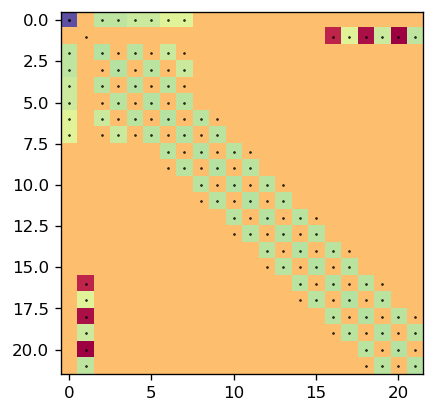

In [476]:
vmin = -np.max(np.abs(Sigma22.todense()))
vmax = +np.max(np.abs(Sigma22.todense()))
plt.figure(dpi=120)
plt.imshow(Sigma22.todense(), cmap='Spectral')
plt.scatter(SIGMA22[1][1], SIGMA22[1][0], c='k', marker='.', s=1)

In [477]:
np.linalg.det(Sigma22.todense())

-0.00012194657478558625

In [478]:
SIGMA12 = get_Sigma12()
Sigma12 = sparse.coo_matrix(SIGMA12, shape=(dim_blk, dim_tot)).tocsc()

In [479]:
print(Sigma12.todense())

[[ 1.          1.          0.97561098  1.97561098  0.85777687  1.88156617
  -0.08947706  0.90595519  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          1.          0.          0.97561098 -0.04817832
   0.90595519 -0.08947706  0.          0.          0.          0.
   0.          0.          0.90595519 -0.90595519  0.97561098 -0.97561098
   1.         -1.          0.          0.        ]
 [ 0.          0.          0.04817832  0.97561098  0.          1.
  -0.04817832  0.97561098  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.97561098  0.04817832  1.          0.
   0.97561098 -0.04817832  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.  

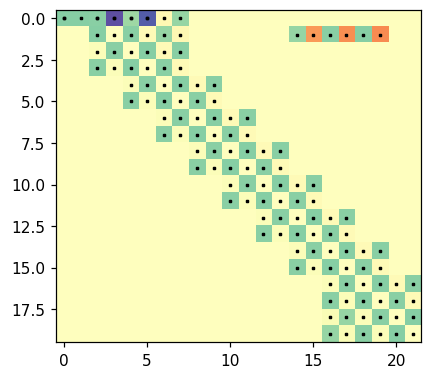

In [480]:
vmin = -np.max(np.abs(Sigma12.todense()))
vmax = +np.max(np.abs(Sigma12.todense()))
plt.figure(dpi=110)
plt.imshow(Sigma12.todense(), cmap='Spectral', vmin=vmin, vmax=vmax)
plt.scatter(SIGMA12[1][1], SIGMA12[1][0], c='k', marker='X', s=2)

In [481]:
condition = get_condition()
condition

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.])

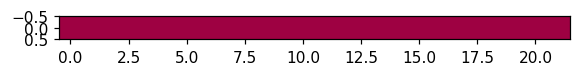

In [482]:
plt.figure(dpi=110)
plt.imshow([condition], cmap='Spectral')

In [483]:
weight = sparse.linalg.spsolve(Sigma22, condition)
result = Sigma12 * weight
result

array([ 95.32872964,  48.52600918,  48.63133462,  48.63052947,
       -41.57174609, -41.48289712,   0.9813108 ,   0.9924828 ,
         0.94233299,   0.93627871,   0.93990964,   0.93495772,
         0.98137717,   0.99251898,   1.43120184,   0.44469784,
         1.47279782,   0.40475329,   1.47666255,   0.47666255])

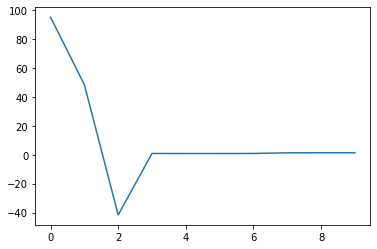

In [485]:
plt.plot(rs, result[::2])